# SETUP AND DEPS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! git clone https://github.com/SwapnilDreams100/calling-out-bluff.git

Cloning into 'calling-out-bluff'...
remote: Enumerating objects: 3471, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 3471 (delta 3), reused 12 (delta 2), pack-reused 3455
Receiving objects: 100% (3471/3471), 908.76 MiB | 17.17 MiB/s, done.
Resolving deltas: 100% (711/711), done.
Checking out files: 100% (3481/3481), done.


In [ ]:
! pip install alibi==0.5.8 xhtml2pdf pdf2image imgkit 
! sudo apt-get install wkhtmltopdf xvfb
# ! apt-get install wkhtmltopdf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 312 kB 35.7 MB/s 
     |████████████████████████████████| 256 kB 63.5 MB/s 
     |████████████████████████████████| 22.3 MB 63.8 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 394.5 MB 41 kB/s 
     |████████████████████████████████| 98.5 MB 112 kB/s 
     |████████████████████████████████| 462 kB 62.0 MB/s 
     |████████████████████████████████| 2.9 MB 47.0 MB/s 
     |████████████████████████████████| 132 kB 58.0 MB/s 
     |████████████████████████████████| 3.8 MB 58.2 MB/s 
     |████████████████████████████████| 14.8 MB 48.8 MB/s 
     |████████████████████████████████| 355 kB 72.5 MB/s 
     |████████████████████████████████| 70 kB 11.0 MB/s 
     |████████████████████████████████| 2.8 MB 55.5 MB/s 
     |████████████████████████████████| 3.1 MB 58.8 MB/s 
     |██████████████████████████

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  avahi-daemon bind9-host geoclue-2.0 geoip-database gstreamer1.0-plugins-base
  iio-sensor-proxy libavahi-core7 libavahi-glib1 libbind9-160 libbrotli1
  libcap2-bin libcdparanoia0 libdaemon0 libdns1100 libgeoclue-2-0 libgeoip1
  libgl1-mesa-glx libgstreamer-plugins-base1.0-0 libgstreamer1.0-0 libhyphen0
  libisc169 libisccc160 libisccfg160 liblwres160 libmbim-glib4 libmbim-proxy
  libmm-glib0 libnl-genl-3-200 libnss-mdns liborc-0.4-0 libpam-cap
  libqmi-glib5 libqmi-proxy libqt5positioning5 libqt5qml5 libqt5quick5
  libqt5sensors5 libqt5svg5 libqt5webchannel5 libqt5webkit5 libvisual-0.4-0
  libwoff1 modemmanager usb-modeswitch usb-modeswitch-data wpasupplicant
Suggested packages:
  avahi-autoipd gvfs 

In [ ]:
! cp ./drive/My\ Drive/glove.6B.300d.txt ./

In [ ]:
!pip install keras==2.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 377 kB 20.5 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [ ]:
essay_type = '7'

import keras.layers as klayers 
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Input, Embedding, GlobalAveragePooling1D, Concatenate, Activation, Lambda, BatchNormalization, Convolution1D, Dropout
from keras.preprocessing.text import Tokenizer
import numpy as np
import nltk
nltk.download('punkt')
# from quadratic_weighted_kappa import QWK
from sklearn.metrics import cohen_kappa_score
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import initializers
from scipy import stats
import matplotlib as mpl
from IPython.display import HTML
from alibi.explainers import IntegratedGradients
import tensorflow.compat.v1 as tf
tf.enable_eager_execution()
import gc
import matplotlib.pyplot as plt
from collections import Counter
import imgkit
options={'xvfb': ''}
# tf.disable_v2_behavior()

Using TensorFlow backend.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# MODEL ARCH

In [ ]:
class Neural_Tensor_layer(Layer):
	def __init__(self,output_dim,input_dim=None, **kwargs):
		self.output_dim=output_dim
		self.input_dim=input_dim
		if self.input_dim:
			kwargs['input_shape']=(self.input_dim,)
# 		print("YAYY", input_dim, output_dim)
		super(Neural_Tensor_layer,self).__init__(**kwargs)

	def call(self,inputs,mask=None):
		e1=inputs[0]
		e2=inputs[1]
		batch_size=K.shape(e1)[0]
		k=self.output_dim
		
		feed_forward=K.dot(K.concatenate([e1,e2]),self.V)

		bilinear_tensor_products = [ K.sum((e2 * K.dot(e1, self.W[0])) + self.b, axis=1) ]

		for i in range(k)[1:]:	
			btp=K.sum((e2*K.dot(e1,self.W[i]))+self.b,axis=1)
			bilinear_tensor_products.append(btp)

		result=K.tanh(K.reshape(K.concatenate(bilinear_tensor_products,axis=0),(batch_size,k))+feed_forward)

		return result
    
	def build(self,input_shape):
		mean=0.0
		std=1.0
		k=self.output_dim
		d=self.input_dim
		##truncnorm generate continuous random numbers in given range
		W_val=stats.truncnorm.rvs(-2 * std, 2 * std, loc=mean, scale=std, size=(k,d,d))
		V_val=stats.truncnorm.rvs(-2 * std, 2 * std, loc=mean, scale=std, size=(2*d,k))
		self.W=K.variable(W_val)
		self.V=K.variable(V_val)
		self.b=K.zeros((self.input_dim,))
		self.trainable_weights.append([self.W,self.V,self.b])

	def compute_output_shape(self, input_shape):
		batch_size=input_shape[0][0]
		return(batch_size,self.output_dim)
  

class Temporal_Mean_Pooling(Layer): # conversion from (samples,timesteps,features) to (samples,features)
	def __init__(self, **kwargs):
		super(Temporal_Mean_Pooling,self).__init__(**kwargs)
		# masked values in x (number_of_samples,time)
		self.supports_masking=True
		# Specifies number of dimensions to each layer
		self.input_spec=InputSpec(ndim=3)
        
	def call(self,x,mask=None):
		if mask is None:
			mask=K.mean(K.ones_like(x),axis=-1)

		mask=K.cast(mask,K.floatx())
				#dimension size single vec/number of samples
		return K.sum(x,axis=-2)/K.sum(mask,axis=-1,keepdims=True)        

	def compute_mask(self,input,mask):
		return None
    
	def compute_output_shape(self,input_shape):
		return (input_shape[0],input_shape[2])

In [ ]:
main_path = './calling-out-bluff/Model3(SkipFlow)/'

In [ ]:
EMBEDDING_DIM=300
MAX_NB_WORDS=4000

MAX_SEQUENCE_LENGTH=500
VALIDATION_SPLIT=0.20
DELTA=20

texts=[]
labels=[]

originals = []

fp1=open("glove.6B.300d.txt","r", encoding="utf-8")
glove_emb={}
for line in fp1:
  temp=line.split(" ")
  try:
    glove_emb[temp[0]]=np.asarray([float(i) for i in temp[1:]])
  except Exception as e:
    pass

In [ ]:
fp=open(main_path+"data/training_set_rel3.tsv",'r', encoding="ascii", errors="ignore")
fp.readline()
originals = []
for line in fp:
    temp=line.split("\t")
    if(temp[1]==essay_type): ## why only 4 ?? - evals in prompt specific fashion
        originals.append(float(temp[6]))
# print(originals)
fp.close()
# print(originals)
print("range min - ", min(originals) , " ; range max - ", max(originals))

range_min = min(originals)
range_max = max(originals)

fp=open(main_path+"data/training_set_rel3.tsv",'r', encoding="ascii", errors="ignore")
fp.readline()
sentences=[]
for line in fp:
    temp=line.split("\t")
    if(temp[1]==essay_type): ## why only 4 ?? - evals in prompt specific fashion
        texts.append(temp[2])
        labels.append((float(temp[6])-range_min)/(range_max-range_min)) ## why ??  - normalize to range [0-1]
        line=temp[2].strip()
        sentences.append(nltk.tokenize.word_tokenize(line))

fp.close()
# MAIN LABELS
orig_labels  = labels

range min -  2.0  ; range max -  24.0


In [ ]:
for i in sentences:
	temp1=np.zeros((1, EMBEDDING_DIM))
	for w in i:
		if(w in glove_emb):
			temp1+=glove_emb[w]
	temp1/=len(i)

In [ ]:
tokenizer=Tokenizer(nb_words = MAX_NB_WORDS) #num_words=MAX_NB_WORDS) #limits vocabulory size
tokenizer.fit_on_texts(texts) #encoding the text
sequences=tokenizer.texts_to_sequences(texts) #returns list of sequences
word_index=tokenizer.word_index #dictionary mapping, word and specific token for that word...
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) #padding to max_length

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 10432 unique tokens.


In [ ]:
# CREATE VALIDATION SET
np.random.seed(0)
indices=np.arange(data.shape[0]) #with one argument, start=0, step =1
print(data.shape)
np.random.shuffle(indices)
data=data[indices]
print(data.shape)
labels=np.asarray(labels)
labels=labels[indices]
# np.reshape(labels, ())
print(labels.shape)
validation_size=int(VALIDATION_SPLIT*data.shape[0])
print(validation_size)

(1569, 500)
(1569, 500)
(1569,)
313


In [ ]:
x_train=data[:-validation_size] #data-validation data
print(x_train.shape)
# print(x_train)
# print(labels)
y_train=labels[:-validation_size]
# print(y_train.transpose)
print(y_train.shape)
# y_train = np.reshape(y_train, (1427, 1))
# print(y_train_new)
# print(y_train)
x_val=data[-validation_size:]
print(x_val.shape)
y_val=labels[-validation_size:]

(1256, 500)
(1256,)
(313, 500)


In [ ]:
embedding_matrix = np.zeros((len(word_index), EMBEDDING_DIM))
for word,i in word_index.items():
	if(i>=len(word_index)):
		continue
	if word in glove_emb:
			embedding_matrix[i]=glove_emb[word]
vocab_size=len(word_index)
print(vocab_size)

10432


In [ ]:
embedding_layer=Embedding(vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],
							input_length=MAX_SEQUENCE_LENGTH,
							mask_zero=True,
							trainable=False)
# print(embedding_layer.shape)
side_embedding_layer=Embedding(vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],
							input_length=MAX_SEQUENCE_LENGTH,
							mask_zero=False,
							trainable=False)

In [ ]:
def SKIPFLOW(lstm_dim=50, lr=1e-4, lr_decay=1e-6, k=4, eta=3, delta=50, activation="relu", maxlen=MAX_SEQUENCE_LENGTH, seed=None):
    e = Input(name='essay',shape=(maxlen,))
    print("e", e)
#     trad_feats=Input(shape=(7,))
#     print("trad_feats", trad_feats)
    embed = embedding_layer(e)
    print(embed.shape)
    lstm_layer=LSTM(lstm_dim,return_sequences=True)
    # print(lstm_layer)
    hidden_states=lstm_layer(embed)
    htm=Temporal_Mean_Pooling()(hidden_states)    
    side_embed = side_embedding_layer(e)
    side_hidden_states=lstm_layer(side_embed)    
    tensor_layer=Neural_Tensor_layer(output_dim=k,input_dim=500)
#     print(input_dim, output_dim)
    pairs = [((eta + i * delta) % maxlen, (eta + i * delta + delta) % maxlen) for i in range(maxlen // delta)]
    hidden_pairs = [ (Lambda(lambda t: t[:, p[0], :])(side_hidden_states), Lambda(lambda t: t[:, p[1], :])(side_hidden_states)) for p in pairs]
    sigmoid = Dense(1, activation="sigmoid", kernel_initializer=initializers.glorot_normal(seed=seed))
    coherence = [sigmoid(tensor_layer([hp[0], hp[1]])) for hp in hidden_pairs]
    co_tm=Concatenate()(coherence[:]+[htm])
    dense = Dense(256, activation=activation,kernel_initializer=initializers.glorot_normal(seed=seed))(co_tm)
    dense = Dense(128, activation=activation,kernel_initializer=initializers.glorot_normal(seed=seed))(dense)
    dense = Dense(64, activation=activation,kernel_initializer=initializers.glorot_normal(seed=seed))(dense)
    out = Dense(1, activation="sigmoid")(dense)
    model = Model(inputs=[e], outputs=[out])
    print("input", [e])
    print("outputs", out)
    adam = Adam(lr=lr, decay=lr_decay)
    model.compile(loss="mean_squared_error", optimizer=adam, metrics=["MSE"])
    return model

In [ ]:
earlystopping = EarlyStopping(monitor="val_mean_squared_error", patience=5)
sf = SKIPFLOW(lstm_dim=500, lr=2e-4, lr_decay=2e-6, k=4, eta=13, delta=50, activation="relu", seed=None)
# sf.summary()

e 

AttributeError: ignored

In [ ]:
# sf.load_weights(main_path+'weights_final/'+essay_type+'_weights.h5')

In [ ]:
# load weights
import pickle
pklfile= "/content/drive/MyDrive/sf_models/7_weights.pkl"
fpkl= open(pklfile, 'rb')
sf.set_weights(pickle.load(fpkl))
print('Weights Loaded')
fpkl.close()

In [ ]:
import pandas as pd
import nltk
from nltk import tokenize
import pickle
from random import shuffle
import random
import numpy as np
from scipy import spatial
from xhtml2pdf import pisa
import math
from alibi.explainers import IntegratedGradients as alibi_ig
import matplotlib as mpl
from collections import Counter
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import os
import copy
import gc

from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1CIEpiDmzLmJ6LMCVSOmCKw_eOg4ocuS4', dest_path='/content/AES.zip', unzip=True)

# get val predictions
preds_main = sf.predict(x_val)
preds_main =[int(round(a*(range_max-range_min)+range_min)) for a in preds_main.flatten().tolist()]

Unzipping...Done.


In [ ]:
# MAIN ADVERSARIAL CLASS - WITH IG METHOD AND ADV SAMPLE GENERATION

class gen_adv_examples:
    def __init__(self, maxlen, tokenizer, prompt, model, input_name, type_ig, model_name, val_preds):
        self.MAX_SEQUENCE_LENGTH = maxlen
        self.tokenizer = tokenizer
        self.word_map = tokenizer.word_index
        self.reversed_word_map = dict(map(reversed, self.word_map.items()))
        self.prompt = prompt
        self.model = model
        self.input_name = input_name
        self.type_ig = type_ig
        prompt_to_range = {'1':[2,12],'2':[1,6],'3':[0,3],'4':[0,3],'5':[0,4],'6':[0,4],'7':[0,30],'8':[0,60]}
        self.range_min = prompt_to_range[self.prompt][0]
        self.range_max = prompt_to_range[self.prompt][1]
        self.model_name = model_name
        self.ATTRS_DIR = '/content/drive/My Drive/IG RESULTS/'+self.model_name+'/P'+self.prompt+'/'
        self.ATTRS_TSV = self.ATTRS_DIR + 'attrs.tsv'
        self.small_preds_orig = []
        self.big_preds_orig   = val_preds

    def normalize(self, labels):
        if type(labels) == 'numpy.ndarray':
          labels_new = labels.flatten().tolist()
        else:
          labels_new = copy.deepcopy(labels)
        l = [0]*len(labels_new)
        for i, label in enumerate(labels_new):
          l[i] = (float(label)-self.range_min)/(self.range_max-self.range_min)
        return l
    
    def denormalize(self, labels):
        if type(labels) == 'numpy.ndarray':
          labels_new = labels.flatten().tolist()
        else:
          labels_new = copy.deepcopy(labels)
        l = [0]*len(labels_new)
        for i, label in enumerate(labels_new):
          if math.isnan(labels_new[i]):
            l[i] = self.range_min
          else:
            l[i] = int(label*(self.range_max-self.range_min) + self.range_min)
        return l

    def vectorize(self, text_array, is_text = False, pad='pre'):
        texts = copy.deepcopy(text_array)
        if is_text:
            texts = self.tokenizer.texts_to_sequences(texts)
        padded_seq = pad_sequences(texts, maxlen = self.MAX_SEQUENCE_LENGTH, padding = pad, truncating = pad)
        return padded_seq
      
    def gen_igs(self, n_steps=50, method="riemann_trapezoid",  batch_size=100):
        self.ig  = alibi_ig(self.model,
                            layer=self.model.get_layer(self.input_name),
                            n_steps=n_steps, 
                            method=method,
                            internal_batch_size=batch_size)
    
    def save_data(self, data, name, is_text=False):
        all_texts = []
        for i,tokens in enumerate(data): 
          d={}
          if not is_text:
            text,_ = self.sequence_to_text(tokens)
          else:
            text = tokens
          d['text'] = ' '.join(text)
          d['label_orig'] = self.labels_orig[i]
          all_texts.append(d)
        df = pd.DataFrame(all_texts)
        df.to_csv('/content/drive/My Drive/IG RESULTS/'+name+'_'+self.prompt+'.csv')

    def make_glove(self, glove_emb):
        self.glove_emb = glove_emb

    def find_closest_embeddings(self, embedding):
        return sorted(self.glove_emb.keys(), key=lambda word: spatial.distance.euclidean(self.glove_emb[word], embedding))[1]
    def top_k_attrs(self, tokens, attrs, k):
        k = min(k, len(tokens))
        return ([tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

    def rindex(self, lst, value):
        lst.reverse()
        i = lst.index(value)
        lst.reverse()
        return len(lst) - i - 1
    
    def normal(self, path = '/content/drive/My Drive/IG RESULTS/'):
        norm = pd.read_csv(path+self.prompt+'_normal.csv')['text'].tolist()
        normal_data = self.vectorize(norm, pad = 'pre', is_text=True)
        preds = self.predict_and_norm(np.array(normal_data))
        self.small_preds_orig = preds
        # self.general_proc(normal_data, self.small_preds_orig, save = True, NAME = 'normal')

    def adv_add_song(self, path = '/content/drive/My Drive/IG RESULTS/'):        
        song_beg = pd.read_csv(path+self.prompt+'_song_beg.csv')['text'].tolist()
        song_end = pd.read_csv(path+self.prompt+'_song_end.csv')['text'].tolist()

        song_beg_data = self.vectorize(song_beg, pad = 'pre', is_text=True)
        song_end_data = self.vectorize(song_end, pad = 'post', is_text=True) 

        self.general_proc(song_beg_data, self.small_preds_orig, save = True, NAME = 'song_beg')
        self.general_proc(song_end_data, self.small_preds_orig, save = True, NAME = 'song_end')
    
    def adv_del(self, path = '/content/drive/My Drive/IG RESULTS/'):
        del_beg = pd.read_csv(path+self.prompt+'_del_beg.csv')['text'].tolist()
        del_end = pd.read_csv(path+self.prompt+'_del_end.csv')['text'].tolist()

        del_beg_data = self.vectorize(del_beg, pad = 'pre', is_text=True)
        del_end_data = self.vectorize(del_end, pad = 'pre', is_text=True)
        self.general_proc(del_beg_data, self.small_preds_orig, save = True, NAME = 'del_beg')
        self.general_proc(del_end_data, self.small_preds_orig, save = True, NAME = 'del_end')

    def adv_modify_syn(self, top_k=10, path = '/content/drive/My Drive/IG RESULTS/'):
        result = []
        norm = pd.read_csv(path+self.prompt+'_normal.csv')['text'].tolist()
        data_test = self.vectorize(norm, pad = 'pre', is_text=True)

        for i,r in enumerate(data_test):
            attrs = self.get_attrs_alibi(np.array([r]))[0]
            res_words,counts = self.sequence_to_text(r)

            assert (len(res_words[counts:]) == len(attrs[counts:]))
            high_attr_tokens = self.top_k_attrs(res_words[counts:],attrs[counts:], top_k)   
            high_attr_tokens = [x for x in high_attr_tokens if x in self.glove_emb.keys()]         
            high_attr_tokens = list(set(list(high_attr_tokens)))
            print(high_attr_tokens)

            syn_dict = {}
            for token in high_attr_tokens:
              syn = self.find_closest_embeddings(self.glove_emb[token])
              # if syn in self.reversed_word_map.keys():
              syn_dict[token] = syn
              # else:
              #   continue
            print(syn_dict)
            for i, token in enumerate(res_words):
                if token in high_attr_tokens:
                    res_words[i] = syn_dict[token]
            result.append(res_words[counts:])
        # res_data = self.vectorize(result, pad='pre', is_text = True)
        self.save_data(result, 'syn', is_text = True)
        
        self.general_proc(res_data, self.small_preds_orig, save = True, NAME = 'syn')
        
    def adv_syn_all(self, percent=0.1, top_k= None):
        import tqdm
        result = []
        syn_dict = {}
        with open(self.ATTRS_TSV) as f:
          for line in tqdm.tqdm(f):
              line = line.strip()
              all_attrs = line.split('\t')[0]
              tokens = []
              attrs = []
              for word_attr in all_attrs.split('||'): 
                  if word_attr == 'done':
                    break
                  word, attr = word_attr.split('|')
                  tokens.append(word)
                  attrs.append(float(attr))
              if top_k == None:
                top_k = int(percent*len(tokens))

              high_attr_tokens = self.top_k_attrs(tokens, attrs, top_k)
              high_attr_tokens = list(set(high_attr_tokens))
              
              for token in high_attr_tokens:
                if token not in syn_dict.keys():
                  try:
                    syn_dict[token] = self.find_closest_embeddings(self.glove_emb[token])
                  except Exception as e:
                    pass
              
              c = 0
              for i, token in enumerate(tokens):
                if token in high_attr_tokens and c<=top_k and token in syn_dict.keys():
                    tokens[i] = syn_dict[token]
                    c+=1
                  
              result.append(tokens)
        res_data = self.vectorize(result, pad='pre', is_text = True)
        self.general_proc(res_data, self.big_preds_orig, save = False, NAME = 'syn_all')

    def adv_babel(self, path):
        babel_csv = pd.read_csv(path, names = ['text'])    
        result = babel_csv['text'].tolist()[:2]
        self.save_data(result, 'babel')
        
        res_data = self.vectorize(result, is_text = True)
        self.general_proc(res_data, self.small_preds_orig, save = True, NAME = 'babel')
        
    def general_proc(self, result, preds_orig, save = False, NAME = None):
        print(NAME+': PREDICTING')
        res_pred = self.predict_and_norm(result)
        
        if save:
          print(NAME+': SAVING')
          if NAME == 'babel':
            res_pred = [self.range_min]*len(result)
          self.save_attrs_pdf(result, preds_orig, res_pred, NAME)

        else:
          print(NAME+': GETTING STATS')
          self.get_pred_stats(preds_orig, res_pred, NAME)

        print(NAME+': DONE')
    
    def remove_tokens(self, data, counts_list, MAX_LEN = 10):
        t_new= []
        l = 0
        for i,v in enumerate(data):
          x_new = []
          l_max = 0
          for w in v:
            if l_max < MAX_LEN:
              if w==0:
                pass
              elif w in counts_list[i]:
                l_max += 1
                pass
              else:
                x_new.append(w)                

            else:
              x_new.append(w)

          l+=len(x_new)
          t_new.append(x_new)
        avg_len = l/len(t_new)
        t_new = self.vectorize(t_new, is_text = True)
        return t_new , avg_len

    def get_data_from_tsv(self):
        data= [] 
        with open(self.ATTRS_TSV) as f:
          for line in f:
            line = line.strip()
            all_attrs = line.split('\t')[0]
            tokens = []
            for word_attr in all_attrs.split('||'):
                if word_attr == 'done':
                  break
                word, _ = word_attr.split('|')
                tokens.append(word)
            data.append(tokens)
        return np.array(data)

    def init_test(self, n = 1, is_abs= False):
        top_counts_list,_ = self.get_top_bottom_attrs(n, is_top = True, is_abs= is_abs)
        bottom_counts_list,_ = self.get_top_bottom_attrs(n, is_top = False, is_abs= is_abs)
        top_counts_list = list(top_counts_list)
        bottom_counts_list = list(bottom_counts_list)
        data = self.get_data_from_tsv()
        assert len(top_counts_list) == len(bottom_counts_list)
        new_top,top_len = self.remove_tokens(data, top_counts_list, MAX_LEN =n)
        new_bottom,bottom_len = self.remove_tokens(data, bottom_counts_list, MAX_LEN =n)

        print(top_len,bottom_len)
        top_pred = self.predict_and_norm(new_top)
        bottom_pred = self.predict_and_norm(new_bottom)

        self.get_pred_stats(self.big_preds_orig, top_pred, 'top')
        self.get_pred_stats(self.big_preds_orig, bottom_pred, 'bottom')
       
    def get_attrs_alibi(self, v = x_val[0:1]):
        baseline = np.zeros(x_val[0:1].shape)
        baseline[0][0] = tokenizer.word_index['a']
        explanation = self.ig.explain(v, baselines=baseline)      
        attrs = explanation.attributions
        attrs = attrs[0].sum(axis=2)      
        return attrs

    def sequence_to_text(self, list_of_indices):
        count = 0
        words = [self.reversed_word_map.get(letter) for letter in list_of_indices]
        for x in words:
          if x == None:
            count+=1
        return(words, count)

    def explain(self, essay):
        attrs = self.get_attrs_alibi(np.array([essay]))[0]
        words,count = self.sequence_to_text(essay)
        assert len(words[count:]) == len(attrs[count:])
        html = self.visualize_token_attrs(words[count:], attrs[count:])
        return attrs, words, count, html

    def visualize_token_attrs(self, tokens, attrs):
        cmap='PiYG'
        cmap_bound = np.abs(attrs).max()
        norm = mpl.colors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
        cmap = mpl.cm.get_cmap(cmap)

        len_tokens = 0
        html_text = "<html><body><style type=\"text/css\"> p { display: inline-block;  width: 183pt;}</style> <p> "
        for i, tok in enumerate(tokens[:60]):
            if tok is not None:
              color = mpl.colors.rgb2hex(cmap(norm(attrs[i])))
              html_text += " <mark style='background-color:{}'>{}</mark>".format(color, tok)
        html_text+=" </p></body></html>"
        print(HTML(html_text))
        return (html_text)

    def visualize_token_attrs_full(self, tokens, attrs):
        cmap='PiYG'
        cmap_bound = np.abs(attrs).max()
        norm = mpl.colors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
        cmap = mpl.cm.get_cmap(cmap)

        len_tokens = 0
        html_text = "<html><body><p> "
        for i, tok in enumerate(tokens):
            if tok is not None:
              color = mpl.colors.rgb2hex(cmap(norm(attrs[i])))
              html_text += " <mark style='background-color:{}'>{}</mark>".format(color, tok)
        html_text+=" </p></body></html>"
        print(html_text)
        return (html_text)

    def convert_html_to_pdf(self, source_html, output_filename):
        result_file = open(output_filename, "w+b")
        pisa_status = pisa.CreatePDF(source_html, dest=result_file)          
        result_file.close()

    def save_attrs_pdf(self, data, labels_orig, labels_new, essay_type):
        dir =  self.ATTRS_DIR+essay_type+'/'
        if not os.path.exists(dir):
          os.makedirs(dir)
        for i,essay in enumerate(data):
          attrs = self.get_attrs_alibi(np.array([essay]))[0]
          words,count = self.sequence_to_text(essay)
          assert len(words[count:]) == len(attrs[count:])
          question_attrs = []
          html = self.visualize_token_attrs(words[count:], attrs[count:])
          self.convert_html_to_pdf(html, dir+str(i)+'_'+str(labels_orig[i])+'_'+str(labels_new[i])+'.pdf')
    
    def save_attrs_tsv(self, data):
        self.ATTRS_TSV = self.ATTRS_DIR + 'attrs.tsv'
        if os.path.isdir(self.ATTRS_DIR):
          pass
        else:
          os.mkdir(self.ATTRS_DIR)
        n = len(data)
        batch = 1
        with open(self.ATTRS_TSV, 'a') as outf:
          c=0
          while c<n:
            ans = ''
            for i,v in enumerate(data[c:c+batch]):
                tsv_string = ''
                attrs = self.get_attrs_alibi(np.array([v]))[0]
                words,count = self.sequence_to_text(v)
                assert len(words[count:]) == len(attrs[count:])
                question_attrs = []
                for ind in range(len(words[count:])):
                  if words[count:][ind] != None and str(attrs[count:][ind])!=None:
                    question_attrs.append(
                        '|'.join([ words[count:][ind], str(attrs[count:][ind]) ])
                        )
                tsv_string = ['||'.join(question_attrs)]
                ans += '\t'.join(tsv_string) + '\n'
                del attrs, words, question_attrs, tsv_string
                gc.collect()
            c+=batch
            print(c)
            outf.write(ans)
            outf.flush()
            del ans
            gc.collect()
        print('DONE ALL')
    
    def top_k_attrs(self, tokens, attrs, k):
        k = min(k, len(tokens))
        return ([tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

    def bottom_k_attrs(self, tokens, attrs, k):
        k = min(k, len(tokens))
        return [tokens[i].strip() for i in np.argpartition(attrs, k)[:k]]

    def get_top_bottom_attrs(self, top_k, is_top = True, is_abs=False): #top k attributions from each line
      counts_list = []
      with open(self.ATTRS_TSV) as f:
          for line in f:
              line = line.strip()
              all_attrs = line.split('\t')[0]
              tokens = []
              attrs = []
              for word_attr in all_attrs.split('||'):
                  if word_attr == 'done':
                    break
                  word, attr = word_attr.split('|')
                  tokens.append(word)
                  if is_abs:
                    attrs.append(abs(float(attr)))
                  else:
                    attrs.append(float(attr))
              try:
                if is_top:
                  counts_list.append(self.top_k_attrs(tokens, attrs, top_k))
                else:
                  counts_list.append(self.bottom_k_attrs(tokens, attrs, top_k))
              except Exception as e:
                pass
      flat_counts_list = [item for sublist in counts_list for item in sublist]
      frequent_attributions = Counter(flat_counts_list)
      if is_top:
        with open(self.ATTRS_DIR+'highest_attrs.txt', 'w') as f:
          attr_to_save = frequent_attributions.most_common(10)
          f.write(str(attr_to_save))
        # frequent_attributions = Counter(counts_list)
      return counts_list, frequent_attributions

    def npos(self, orig, new):
      count = 0
      for i in range(len(orig)):
        if new[i]>orig[i]:
          count+=1 
      return count

    def nneg(self, orig, new):
      count = 0
      for i in range(len(orig)):
        if new[i]<orig[i]:
          count+=1 
      return count

    def nsame(self, orig, new):
      count = 0
      for i in range(len(orig)):
        if new[i]==orig[i]:
          count+=1 
      return count

    def get_pred_stats(self, orig, new, name):
      # a = ('kappa', cohen_kappa_score(orig, new, weights='quadratic'))
      b = ('NPOS', self.npos(orig, new))
      c = ('NNEG', self.nneg(orig, new))
      d = ('NSAME', self.nsame(orig, new))
      with open(self.ATTRS_DIR+ 'results_'+name+'.txt', 'w') as f:
        f.write(str([b,c,d]))
      
    def get_overstability_data(self, data, labels, top_k=100, spacing = 10):
      curve_data = {}
      counts_list,_ = self.get_top_bottom_attrs(top_k, is_top=True) 
      if type(counts_list[0]) == list:
        counts_list = [item for sublist in counts_list for item in sublist]
      preds_orig = self.predict_and_norm(np.array(data))
      # print(preds_orig, labels)
      orig_acc = cohen_kappa_score(preds_orig, labels, weights='quadratic')
          
      for K in np.append(0, np.unique(np.floor(np.geomspace(1, len(Counter(counts_list)), spacing)))):
          # take K most top attributed words
          if K in curve_data:
              continue
          whitelist = set([self.word_map[w] for w in counts_list[:int(K)]]) if K > 0 else set()
          print('wh len', len(whitelist))
          num_batches = 0
          avg_question_length_orig = 0
          avg_question_length_new = 0
          num_questions = 0
          pred_array = []
          batch_size = 10
          # iterator over the validation dataset
          for ind in range(0, len(data), batch_size):

              test = np.array(data[ind:ind+batch_size])
              new_test = np.zeros(test.shape)
              curr_batch_size = int(test.shape[0])
              for batch_i in range(curr_batch_size):
                  len_counter = 0
                  # avg_question_length_orig += int(test[batch_i])
                  for word_i, w in enumerate(test[batch_i]):
                      if int(w) in whitelist:
                          new_test[batch_i, len_counter] = int(w)
                          len_counter += 1
                  if len_counter == 0:
                      len_counter = 1
                  avg_question_length_new += int(len_counter)
                  num_questions += 1
                  
              input_df = [new_test]
              pred = self.predict_and_norm(input_df)
              pred_array.extend(pred)

          acc = cohen_kappa_score(pred_array, labels, weights='quadratic')
          print(acc, orig_acc)
          curve_data[len(whitelist)] = acc
          self.plot_overstability(curve_data, orig_acc)
    
    def plot_overstability(self, curve_data, orig_acc):
      OVERSTABILITY_CURVE_FILE = self.ATTRS_DIR + 'over_'+self.prompt+'.eps'
      plt.plot(list(curve_data.keys()), list(curve_data.values())/orig_acc)
      plt.xscale('symlog')
      plt.xlabel('num. words in vocab')
      plt.ylabel('relative accuracy')
      plt.savefig(OVERSTABILITY_CURVE_FILE, format='eps')
      plt.savefig(OVERSTABILITY_CURVE_FILE.replace('eps','png'), format='png')
    
    def predict_and_norm(self, data):
      preds = self.model.predict(data)
      new_labels = self.denormalize(preds)
      return new_labels

In [ ]:
#INIT CLASS
adv = gen_adv_examples(MAX_SEQUENCE_LENGTH, tokenizer, essay_type, sf, 'embedding','alibi', 'SKIPFLOW', preds_main)

# CREATE IG CLASS
adv.gen_igs()
# data, labels = adv.choose_examples(x_val, y_val)
# labels_main = adv.denormalize(y_val)
# adv.make_glove(path = '')

## TRIGGERS

In [ ]:
triggers = pd.read_csv('/content/Stats.csv')

In [ ]:
p7_triggers = triggers[triggers['prompt'] == 7]['trigger'].tolist()

In [ ]:
adv_data = pd.read_csv('/content/drive/My Drive/IG RESULTS/7_normal.csv')

In [ ]:
essay = adv_data['text'][1]
new_samples = [x+' '+essay for x in p7_triggers]

In [ ]:
texts = tokenizer.texts_to_sequences([new_samples[21]])
padded_seq = pad_sequences(texts, maxlen = MAX_SEQUENCE_LENGTH, padding = 'pre', truncating = 'pre')
attrs, words, _, html_sam = adv.explain(padded_seq[0])

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


<IPython.core.display.HTML object>


In [ ]:
HTML(html_sam)

## RESUME

In [ ]:
# word_map = tokenizer.word_index
# reversed_word_map = dict(map(reversed, word_map.items()))

# ig = alibi_ig(sf,
#               layer=sf.get_layer('embedding'),
#               n_steps=50, 
#               method='riemann_trapezoid',
#               internal_batch_size=100)

# def vectorize(text_array, is_text = False, pad='pre'):
#         texts = copy.deepcopy(text_array)
#         if is_text:
#             texts = tokenizer.texts_to_sequences(texts)
#         padded_seq = pad_sequences(texts, maxlen = MAX_SEQUENCE_LENGTH, padding = pad, truncating = pad)
#         return padded_seq

# def get_attrs_alibi(v = x_val[0:1]):
#         baseline = np.zeros(x_val[0:1].shape)
#         baseline[0][0] = tokenizer.word_index['a']
#         explanation = ig.explain(v, baselines=baseline)      
#         attrs = explanation.attributions
#         print(attrs)
#         attrs = attrs.sum(axis=2)      
#         return attrs
        
# def sequence_to_text(list_of_indices):
#     count = 0
#     words = [reversed_word_map.get(letter) for letter in list_of_indices]
#     for x in words:
#       if x == None:
#         count+=1
#     return(words, count)

# a = get_attrs_alibi(np.array(x_val[0:1]))[0]
# words,count = sequence_to_text(x_val[0])

# from xhtml2pdf import pisa
# def convert_html_to_pdf(source_html, output_filename):
#   result_file = open(output_filename, "w+b")
#   pisa_status = pisa.CreatePDF(source_html, dest=result_file)          
#   result_file.close()

# html_full = adv.visualize_token_attrs_full(words[count:], a[count:])
# convert_html_to_pdf(html_full, './test.pdf')
# HTML(html_full)

In [ ]:
from xhtml2pdf import pisa
def convert_html_to_pdf(source_html, output_filename):
  result_file = open(output_filename, "w+b")
  pisa_status = pisa.CreatePDF(source_html, dest=result_file)          
  result_file.close()

html_full = adv.visualize_token_attrs_full(words[count:], a[count:])
convert_html_to_pdf(html_full, './test.pdf')
HTML(html_full)

# generate ADVERSARIAL EXAMPLES

In [ ]:
pattern_none = [0, 0, 0, 0, 0]
def subfinder(l, sl):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1

def get_loc(w):
  count = 0
  for x in w:
    if x == 0:
      count+=1
  return count

In [ ]:
a = []
ids = []
count = 0
for i,essay in enumerate(data):
  c = get_loc(essay)
  c2 = len(essay[c:])
  if c2>200 and c2<250 and count<10:
    a.append(c2)
    ids.append(i)
    count+=1

In [ ]:
lab = adv.denormalize(labels)
min_val = min(lab)
max_val = max(lab)
avg_val = (min_val+max_val)//2
min_idxs = [i for i, value in enumerate(lab) if value == min_val][:3]
max_idxs = [i for i, value in enumerate(lab) if value == max_val][:3]
avg_idxs = [i for i, value in enumerate(lab) if value == avg_val][:3]
indices = min_idxs + max_idxs + avg_idxs
print(len(indices))
labels_orig = [min_val]*len(min_idxs) + [max_val]*len(max_idxs) + [avg_val]*len(avg_idxs)
data = [texts[i] for i in indices]

In [ ]:
def denormalize(labels, max_val, min_val):
        if type(labels) == 'numpy.ndarray':
          labels_new = labels.flatten().tolist()
        else:
          labels_new = copy.deepcopy(labels)
        l = [0]*len(labels_new)
        for i, label in enumerate(labels_new):
          if math.isnan(labels_new[i]):
            l[i] = max_val+1
          else:
            l[i] = int(label*(max_val-min_val) + min_val)
        return l

# lab = denormalize(orig_labels, 30 , 0)
lab = denormalize(y_train, 30 , 0)

In [ ]:
data = tokenizer.sequences_to_texts(x_train)

## NEAREST NEIGHBOURS

In [ ]:
!pip install annoy

     |████████████████████████████████| 655kB 25.3MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391595 sha256=3ce1140f71c0d55e80d7c8b906a59c5c0f01b294d2651318ce1b8f1946ccb487
  Stored in directory: /root/.cache/pip/wheels/3a/c5/59/cce7e67b52c8e987389e53f917b6bb2a9d904a03246fadcb1e
Successfully built annoy


In [ ]:
!wget https://archive.org/download/glove.6B.50d-300d/glove.6B.50d.txt

--2021-05-11 12:40:26--  https://archive.org/download/glove.6B.50d-300d/glove.6B.50d.txt
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia803006.us.archive.org/1/items/glove.6B.50d-300d/glove.6B.50d.txt [following]
--2021-05-11 12:40:26--  https://ia803006.us.archive.org/1/items/glove.6B.50d-300d/glove.6B.50d.txt
Resolving ia803006.us.archive.org (ia803006.us.archive.org)... 207.241.233.26
Connecting to ia803006.us.archive.org (ia803006.us.archive.org)|207.241.233.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171350079 (163M) [text/plain]
Saving to: ‘glove.6B.50d.txt’

glove.6B.50d.txt    100%[===================>] 163.41M   528KB/s    in 2m 57s  

2021-05-11 12:43:24 (944 KB/s) - ‘glove.6B.50d.txt’ saved [171350079/171350079]



In [ ]:
# from annoy import AnnoyIndex

# file = "/content/glove.6B.50d.txt"
# content = []
# with open(file) as f:
#     content = f.readlines()

# content = [x.split(" ") for x in content]

In [ ]:
# t = AnnoyIndex(50,'euclidean') 
# idx = 0
# terms = [i[0] for i in content]
# for i in content:
#   vec = [float(a) for a in i[1:]]
#   t.add_item(idx, vec)
#   idx = idx + 1

# t.build(10) # 10 trees
# t.save('test50.ann')

True

## RESUME

In [ ]:
word_map = tokenizer.word_index
reversed_word_map = dict(map(reversed, word_map.items()))

ig = alibi_ig(sf,
              layer=sf.get_layer('embedding'),
              n_steps=50, 
              method='riemann_trapezoid',
              internal_batch_size=100)

def vectorize(text_array, is_text = False, pad='pre'):
        texts = copy.deepcopy(text_array)
        if is_text:
            texts = tokenizer.texts_to_sequences(texts)
        padded_seq = pad_sequences(texts, maxlen = MAX_SEQUENCE_LENGTH, padding = pad, truncating = pad)
        return padded_seq

# save the data in csv
def save_data(data, name, labels_orig, is_text=False):
        all_texts = []
        for i,tokens in enumerate(data): 
          d={}
          if not is_text:
            text,_ = sequence_to_text(tokens)
          else:
            text = tokens
          d['text'] = ' '.join(text)
          d['label_orig'] = labels_orig[i]

          all_texts.append(d)
        df = pd.DataFrame(all_texts)
        df.to_csv('/content/drive/My Drive/IG RESULTS/'+name+'_'+self.prompt+'.csv')

def get_attrs_alibi(v = x_val[0:1]):
        baseline = np.zeros(x_val[0:1].shape)
        baseline[0][0] = tokenizer.word_index['a']
        explanation = ig.explain(v, baselines=baseline)      
        attrs = explanation.attributions
        print(attrs)
        attrs = attrs.sum(axis=2)      
        return attrs
        
def sequence_to_text(list_of_indices):
    count = 0
    words = [reversed_word_map.get(letter) for letter in list_of_indices]
    for x in words:
      if x == None:
        count+=1
    return(words, count)

def find_closest_embeddings(embedding):
    return sorted(glove_emb.keys(), key=lambda word: spatial.distance.euclidean(glove_emb[word], embedding))[1]

def find_closest_embeddings_annoy(word): # 100X FASTER LOL
    u = AnnoyIndex(50, 'euclidean')
    u.load('test50.ann')
    near = u.get_nns_by_item(terms.index(word.lower()), 2) # nearest 10 terms
    nearWord = [terms[i] for i in near][1]
    u.unload()
    return(nearWord)

def top_k_attrs(tokens, attrs, k):
    k = min(k, len(tokens))
    return ([tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

def bottom_k_attrs(tokens, attrs, k):
    k = min(k, len(tokens))
    return [tokens[i].strip() for i in np.argpartition(attrs, k)[:k]]

def adv_modify_syn(percent=0.10, path = '/content/drive/My Drive/IG RESULTS/', prompt= '7', small= True, data_norm = None):
        result = []
        if small:
          norm = pd.read_csv(path+prompt+'_normal.csv')['text'].tolist()
        elif data_norm:
          norm = data_norm
        else:
          norm = pd.read_csv(path+'big_'+prompt+'_normal.csv')['text'].tolist()
        data_test = vectorize(norm, pad = 'pre', is_text=True)
        if data_norm:
            for i,r in enumerate(data_test):
              print(i,len(data_test))
              res_words,counts = sequence_to_text(r)
              top_k = int(2*percent*len(res_words[counts:]))
              possible_words = list(set(res_words[counts:]))
              tokens = [x for x in possible_words if x in glove_emb.keys()]         
              tokens = random.sample(tokens, top_k)
              
              syn_dict = {}
              for token in tokens:
                syn = find_closest_embeddings_annoy(token)
                syn_dict[token] = syn

              c_high = 0
              for i, token in enumerate(res_words):
                  if token in tokens and c_high<=top_k:
                      res_words[i] = syn_dict[token]
                      c_high += 1

              text = (res_words[counts:])
              result.append(' '.join(text))
            print(syn_dict)
            return result  

        for i,r in enumerate(data_test):
          attrs = get_attrs_alibi(np.array([r]))[0]
          res_words,counts = sequence_to_text(r)
          top_k = int(percent*len(res_words[counts:]))
          high_attr_tokens = top_k_attrs(res_words[counts:],attrs[counts:], top_k)   
          high_attr_tokens = [x for x in high_attr_tokens if x in glove_emb.keys()]         
          high_attr_tokens = list(set(list(high_attr_tokens)))
          
          attrs_abs = [abs(x) for x in attrs[counts:]]
          low_attr_tokens = bottom_k_attrs(res_words[counts:],attrs_abs, top_k)   
          low_attr_tokens = [x for x in low_attr_tokens if x in glove_emb.keys()]         
          low_attr_tokens = list(set(list(low_attr_tokens)))

          syn_dict = {}
          for token in high_attr_tokens:
            syn = find_closest_embeddings_annoy(token)
            syn_dict[token] = syn

          for token in low_attr_tokens:
            syn = find_closest_embeddings_annoy(token)
            syn_dict[token] = syn
          
          c_high = 0
          c_low  = 0
          for i, token in enumerate(res_words):
              if token in high_attr_tokens and c_high<=top_k:
                  res_words[i] = syn_dict[token]
                  c_high += 1

              elif token in low_attr_tokens and c_low<=top_k:
                  res_words[i] = syn_dict[token]
                  c_low +=1

          text = (res_words[counts:])
          result.append(' '.join(text))
        print(syn_dict)
        return result

In [ ]:
import random
random.seed(42)

# save the SMALL - 8 sample data
def save(data, out, name):
  all_texts = []
  for i,text in enumerate(data): 
    d={}
    d['text'] = text
    d['label_orig'] = out[i]
    all_texts.append(d)
  df = pd.DataFrame(all_texts)
  df.to_csv('/content/drive/My Drive/IG RESULTS/7_'+name+'.csv')

def create_small_data(texts, lab):
    min_val = min(lab)
    max_val = max(lab)
    avg_val = (min_val+max_val)//2
    min_idxs = [i for i, value in enumerate(lab) if value == min_val][:3]
    max_idxs = [i for i, value in enumerate(lab) if value == max_val][:3]
    avg_idxs = [i for i, value in enumerate(lab) if value == avg_val][:3]
    ids = min_idxs + max_idxs + avg_idxs
    data = [texts[i] for i in ids]
    labs_new = [lab[i] for i in ids]
    
    path = 'song.pickle'    
    with open('/content/calling-out-bluff/'+path, 'rb') as handle:
        songs= pickle.load(handle)
    song_tot = songs[:4]+songs[10:16]

    false_tot = [ 'There are more submarines in lakes right now than there are in the oceans. ', \
          'Apples are not fruits. ',\
          'The world is flat. ']

    song_beg = []
    song_end = []
    for i in range(len(data)):
      random_song = random.choice(song_tot)
      song_beg.append(random_song + data[i])
      song_end.append(data[i] + random_song)
  
    false_beg = []
    false_end = []
    for i in range(len(data)):
      random_false = random.choice(false_tot)
      false_beg.append(random_false +' '+ data[i])
      false_end.append(data[i] + ' ' + random_false)

    def scramble(sentence):
        split = tokenize.sent_tokenize(sentence)
        shuffle(split)  # This shuffles the list in-place.
        return ''.join(split)  # Turn the list back into a string

    shuffled=[]
    for i in range(len(data)):
      shuffled.append( scramble(  data[i]   ) ) 

    
    out = labs_new
    
    # save(data, out, 'normal')
    # save(song_beg, out, 'song_beg')
    # save(song_end, out, 'song_end')
    # save(false_beg, out, 'false_beg')
    # save(false_end, out, 'false_end')
    # save(shuffled, out, 'shuffle')
    return out
    
out = create_small_data(texts, lab)

# syn_result = adv_modify_syn(prompt = '7')
# save(syn_result, out, 'syn')

In [ ]:
# save the BIG data of 100 samples
def save_big(data, out, name):
  all_texts = []
  for i,text in enumerate(data): 
    d={}
    d['text'] = text
    d['label_orig'] = out[i]
    all_texts.append(d)
  df = pd.DataFrame(all_texts)
  # df.to_csv('/content/drive/My Drive/IG RESULTS/big_7_'+name+'.csv')
  df.to_csv('/content/drive/My Drive/IG RESULTS/ADV_DATA/TRAINING/7_'+name+'.csv')

def create_big_data(texts, lab, n = -1):
    data = texts[:n]
    labs_new = lab[:n]

    path = 'song.pickle'    
    with open('/content/calling-out-bluff/'+path, 'rb') as handle:
        songs= pickle.load(handle)
    song_tot = songs[:4]+songs[10:16]

    false_tot = [ 'There are more submarines in lakes right now than there are in the oceans. ', \
          'Apples are not fruits. ',\
          'The world is flat. ']

    song_beg = []
    song_end = []
    for i in range(len(data)):
      random_song = random.choice(song_tot)
      song_beg.append(random_song + data[i])
      song_end.append(data[i] + random_song)
  
    false_beg = []
    false_end = []
    for i in range(len(data)):
      random_false = random.choice(false_tot)
      false_beg.append(random_false +' '+ data[i])
      false_end.append(data[i] + ' ' + random_false)

    def scramble(sentence):
        split = tokenize.sent_tokenize(sentence)
        shuffle(split)  # This shuffles the list in-place.
        return ''.join(split)  # Turn the list back into a string

    shuffled=[]
    for i in range(len(data)):
      shuffled.append( scramble(  data[i]   ) ) 
    
    out = labs_new
    
    # save_big(data, out, 'normal')
    # save_big(song_beg, out, 'song_beg')
    # save_big(song_end, out, 'song_end')
    # save_big(false_beg, out, 'false_beg')
    # save_big(false_end, out, 'false_end')
    # save_big(shuffled, out, 'shuffle')
    return out
    
out = create_big_data(data, lab)

In [ ]:
len(out)

1255

In [ ]:
len(out)

1255

In [ ]:
syn_result = adv_modify_syn(small = False, prompt = '7', data_norm = data[:-1])
save_big(syn_result, out, 'syn')

0 1255
1 1255
2 1255
3 1255
4 1255
5 1255
6 1255
7 1255
8 1255
9 1255
10 1255
11 1255
12 1255
13 1255
14 1255
15 1255
16 1255
17 1255
18 1255
19 1255
20 1255
21 1255
22 1255
23 1255
24 1255
25 1255
26 1255
27 1255
28 1255
29 1255
30 1255
31 1255
32 1255
33 1255
34 1255
35 1255
36 1255
37 1255
38 1255
39 1255
40 1255
41 1255
42 1255
43 1255
44 1255
45 1255
46 1255
47 1255
48 1255
49 1255
50 1255
51 1255
52 1255
53 1255
54 1255
55 1255
56 1255
57 1255
58 1255
59 1255
60 1255
61 1255
62 1255
63 1255
64 1255
65 1255
66 1255
67 1255
68 1255
69 1255
70 1255
71 1255
72 1255
73 1255
74 1255
75 1255
76 1255
77 1255
78 1255
79 1255
80 1255
81 1255
82 1255
83 1255
84 1255
85 1255
86 1255
87 1255
88 1255
89 1255
90 1255
91 1255
92 1255
93 1255
94 1255
95 1255
96 1255
97 1255
98 1255
99 1255
100 1255
101 1255
102 1255
103 1255
104 1255
105 1255
106 1255
107 1255
108 1255
109 1255
110 1255
111 1255
112 1255
113 1255
114 1255
115 1255
116 1255
117 1255
118 1255
119 1255
120 1255
121 1255
122 1255
123

# SAVE ATTRIBUTION

In [ ]:
import gc
import multiprocessing

word_map = tokenizer.word_index
reversed_word_map = dict(map(reversed, word_map.items()))

ig = alibi_ig(sf,
              layer=sf.get_layer('embedding'),
              n_steps=50, 
              method='riemann_trapezoid',
              internal_batch_size=100)

def vectorize(text_array, is_text = False, pad='pre'):
  texts = copy.deepcopy(text_array)
  if is_text:
      texts = tokenizer.texts_to_sequences(texts)
  padded_seq = pad_sequences(texts, maxlen = MAX_SEQUENCE_LENGTH, padding = pad, truncating = pad)
  return padded_seq

def sequence_to_text(list_of_indices):
    count = 0
    words = [reversed_word_map.get(letter) for letter in list_of_indices]
    for x in words:
      if x == None:
        count+=1
    return(words, count)

def get_attrs_alibi(v = x_val[0:1]):
        baseline = np.zeros(x_val[0:1].shape)
        baseline[0][0] = tokenizer.word_index['a']
        explanation = ig.explain(v, baselines=baseline)      
        attrs = explanation.attributions
        attrs = attrs.sum(axis=2)      
        return attrs

def create_model_and_train( attr_type = 'add'):

  ATTRS_DIR = './drive/My Drive/IG RESULTS/'
  ATTRS_TSV = ATTRS_DIR+'SKIPFLOW/P7/attrs_'+attr_type+'.tsv'
  
  data = pd.read_csv(ATTRS_DIR+'big_7_'+attr_type+'.csv')['text'].tolist()
  data_test = vectorize(data, pad = 'pre', is_text=True)
  with open(ATTRS_TSV, 'w') as outf:
    ans = ''
    for i,v in enumerate(data_test):
        tsv_string = ''
        attrs = get_attrs_alibi(np.array([v]))[0]
        words,count = sequence_to_text(v)
        assert len(words[count:]) == len(attrs[count:])
        question_attrs = []
        for ind in range(len(words[count:])):
          if words[count:][ind] is not None:
            question_attrs.append(
                '|'.join([ words[count:][ind], str(attrs[count:][ind]) ])
                )
        tsv_string = ['||'.join(question_attrs)]
        ans += '\t'.join(tsv_string) + '\n'
        del attrs, words, question_attrs, tsv_string
        gc.collect()
    outf.write(ans)
    outf.flush()
    del ans
    gc.collect()
    outf.write('done')
  print('DONE')

In [ ]:
attr_type = 'song_beg'
create_model_and_train(attr_type)

gc.collect()

attr_type = 'song_end'
create_model_and_train(attr_type)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

DONE


It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

DONE


In [ ]:
gc.collect()

0

In [ ]:
attr_type = 'false_beg'
create_model_and_train(attr_type)

gc.collect()

attr_type = 'false_end'
create_model_and_train(attr_type)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

DONE


It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

DONE


In [ ]:
gc.collect()

0

In [ ]:
attr_type = 'normal'
create_model_and_train(attr_type)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

DONE


In [ ]:
# attr_type = 'shuffle'
# create_model_and_train(attr_type)

gc.collect()

attr_type = 'syn'
create_model_and_train(attr_type)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

DONE


In [ ]:
gc.collect()

0

# LOAD ADVERSARIAL EXAMPLES AND ATTRIBUTIONS

In [ ]:
ATTRS_DIR = '/content/drive/My Drive/IG RESULTS/SKIPFLOW/P7/'
ATTRS_TSV = '/content/drive/My Drive/IG RESULTS/SKIPFLOW/P7/attrs.tsv'

In [ ]:
import pandas as pd
essay_set_id = '7'
names = ['song_beg', 'song_end', 'false_beg','false_end','normal','shuffle', 'syn','incomp_data']
adv_data_list = {}
for name in names:
  adv_data = pd.read_csv('/content/drive/My Drive/IG RESULTS/'+str(essay_set_id)+'_'+name+'.csv')
  adv_data_list[name] = adv_data

In [ ]:
E_list = {}
labels_true = []
labels_syn = []
for adv_data in adv_data_list.keys():
    if adv_data == 'normal':
      texts = adv_data_list[adv_data]['text'].tolist()
      labels_true = adv_data_list[adv_data]['label_orig'].tolist()
    elif adv_data == 'incomp_data':
      texts = adv_data_list[adv_data]['essay'].tolist()
      labels_true = adv_data_list[adv_data]['label_orig'].tolist()
    elif adv_data == 'syn':
      texts = adv_data_list[adv_data]['text'].tolist()
      labels_syn  = adv_data_list[adv_data]['label_orig'].tolist()
    else:
      texts = adv_data_list[adv_data]['text'].tolist()
      labels_true = adv_data_list[adv_data]['label_orig'].tolist()
    sequences=tokenizer.texts_to_sequences(texts) #returns list of sequences
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) #padding to max_length
    E_list[adv_data]= data

In [ ]:
e   = E_list['normal']
labels_orig = adv.predict_and_norm(e)
labels_orig

[3, 24, 28, 26, 15, 15, 10]

### PROCESS ADV SAMPLES AND SAVE POPULATION STATISTICS

In [ ]:
from xhtml2pdf import pisa
def convert_html_to_pdf(source_html, output_filename):
  result_file = open(output_filename, "w+b")
  pisa_status = pisa.CreatePDF(source_html, dest=result_file)          
  result_file.close()

def save_stats_add(diff, diff_attr, word_list, ratio,output_filename):
  result = open(output_filename, 'w')
  result.write('\ndiff in scores:  '+str(diff))
  result.write('\ndiff in attrs:  '+ str(diff_attr))
  result.write('\nnew words in top 10%:  '+ ', '.join(word_list))
  result.write('\npercent of top words in added words:  '+ str(ratio))
  result.close()

def save_stats_mod(diff, diff_attr, changed_no,output_filename):
  result = open(output_filename, 'w')
  result.write('\ndiff in scores:  '+str(diff))
  result.write('\ndiff in attrs:  '+ str(diff_attr))
  result.write('\nno of words which changed attr:  '+ str(changed_no))
  result.close()

def save_stats_gen(babel_total, babel_unattrib, output_filename):
  result = open(output_filename, 'w')
  result.write('\ntop attributed words:  '+ str(babel_total))
  result.write('\ntop unattributed words:  '+ str(babel_unattrib))
  result.close()

def top_k_attrs(tokens, attrs, sign = None, k=None):
    k = min(k, len(tokens))
    
    if sign != None:
      tokens_list = []
      signs_list = []
      for i in np.argpartition(attrs, -k)[-k:]:
          tokens_list.append(tokens[i].strip())
          signs_list.append(sign[i])
      return  tokens_list , signs_list
    
    else:
      return ([tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

def bottom_k_attrs(tokens, attrs, k):
    k = min(k, len(tokens))
    return [tokens[i].strip() for i in np.argpartition(attrs, k)[:k]]

def save_normal_attrs(data, labels_orig, essay_type):
  dir =  ATTRS_DIR+essay_type+'/'
  if not os.path.exists(dir):
    os.makedirs(dir)

  a_total = []
  w_total= [] 
  for i,essay in enumerate(data):
    attrs, words, c= adv.explain(data[i])
    label_new = adv.predict_and_norm(data[i:i+1])[0]
    html = adv.visualize_token_attrs(words[c:], attrs[c:])
    html_full = adv.visualize_token_attrs_full(words[c:], attrs[c:])

    convert_html_to_pdf(html, dir+str(i)+'_'+str(labels_orig[i])+'_'+str(label_new+0)+'.pdf')
    convert_html_to_pdf(html_full, dir+str(i)+'_'+str(labels_orig[i])+'_'+str(label_new+0)+'.pdf')

    a_total.append(attrs)
    w_total.append(words)

  return a_total, w_total

def get_loc(w):
  count = 0
  for x in w:
    if x == None:
      count+=1
  
  return count

# def save_attrs_pdf(data, data_normal, labels_orig, essay_type, type_add = False, type_mod = False, type_gen = False):
#   dir =  ATTRS_DIR+essay_type+'/'
#   if not os.path.exists(dir):
#     os.makedirs(dir)

#   a,w = data_normal
#   babel_total = {}
#   babel_unattrib = {}

#   for i,essay in enumerate(data):
#     attrs, words,c_data = adv.explain(data[i])
#     labels_new = adv.predict_and_norm(data[i:i+1])[0]
#     if not type_gen:
#       c_normal = get_loc(w[i])
#       a_normal = a[i][c_normal:]
#       w_normal = w[i][c_normal:]

#     a_data = attrs[c_data:]
#     w_data = words[c_data:]

#     if type_add:
#         diff = labels_orig[i] - labels_new
#         diff_attr = sum(attrs) - sum(a[i])

#         if essay_type == 'song_beg' or essay_type =='false_beg' :

#           pattern = w_normal[:4]
#           try:
#             loc = subfinder(w_data, pattern)[0]
#           except Exception as e:
#             loc = len(w_data)
#           new_w = w_data[:loc]
#           new_a = a_data[:loc]

#         elif essay_type == 'song_end' or essay_type =='false_end':

#           loc = len(w_normal[i])
#           new_w = w_data[loc:]
#           new_a = a_data[loc:]

#         top_words_normal = top_k_attrs(w_normal, a_normal, k = int(0.1*len(w_normal)))
        
#         top_words_data   = top_k_attrs(w_data,   a_data,   k = int(0.1*len(w_data)))

#         top_words_final = [x for x in top_words_data if x not in top_words_normal]

#         html = adv.visualize_token_attrs(w_data, a_data)
#         convert_html_to_pdf(html, dir+str(i)+'_'+str(labels_orig[i])+'_'+str(labels_new+0)+'.pdf')
#         save_stats_add(diff, diff_attr, top_words_final, len(top_words_final)/len(new_w), dir+'stats_'+str(i)+'_'+str(labels_orig[i])+'_'+str(labels_new+0)+'.txt')
    
#     elif type_gen:
#         attrs_sign= []
#         for x in a_data:
#             if x>0:
#               attrs_sign.append('+')
#             else:
#               attrs_sign.append('-')

#         top_words, top_words_signs = top_k_attrs(w_data, a_data, attrs_sign, k = int(0.1*len(w_data)))
        
#         for j,x in enumerate(top_words):
#           if x in babel_total.keys():
#             if top_words_signs[j] == '+':
#               babel_total[x][0]+=1
#             else:
#               babel_total[x][1]+=1
#           else:
#             if top_words_signs[j] == '+':
#               babel_total[x] = [1,0]
#             else:
#               babel_total[x] = [0,1]
        
#         attrs_abs = [abs(x) for x in a_data]
#         bottom_words = bottom_k_attrs(w_data, attrs_abs, k = int(0.1*len(w_data)))
        
#         for j,x in enumerate(bottom_words):
#           if x in babel_unattrib.keys():
#             babel_unattrib[x]+= 1
#           else:
#             babel_unattrib[x] = 1

#         html = adv.visualize_token_attrs(w_data, a_data)
#         convert_html_to_pdf(html, dir+str(i)+'_'+str(labels_new+0)+'.pdf')

#     elif type_mod:
#         diff = labels_orig[i] - labels_new
#         diff_attr = sum(attrs) - sum(a[i])
        
#         if essay_type == 'shuffle' or essay_type == 'syn':
#           attrs_abs=[]
#           attrs_sign =[]
#           for x in a_normal:
#             attrs_abs.append(abs(x))
#             if x>0:
#               attrs_sign.append('+')
#             else:
#               attrs_sign.append('-')

#           top_words_orig, token_signs_orig = top_k_attrs(w_normal, attrs_abs, attrs_sign, k = int(0.1*len(w_normal)))
          
#           attrs_abs=[]
#           attrs_sign =[]
#           for x in a_data:
#             attrs_abs.append(abs(x))
#             if x>0:
#               attrs_sign.append('+')
#             else:
#               attrs_sign.append('-')
          
#           top_words, token_signs = top_k_attrs(w_data, attrs_abs, attrs_sign, k = int(0.1*len(w_data)))
          
#           changed_count = 0

#           for orig_index,t in enumerate(top_words_orig):
#             try:
#               ind = top_words.index(t)
#             except Exception as e:
#               ind = -1

#             if ind!=-1:
#               if token_signs_orig[orig_index] != token_signs[ind]:
#                   changed_count+=1

#         html = adv.visualize_token_attrs(w_data, a_data)
#         convert_html_to_pdf(html, dir+str(i)+'_'+str(labels_orig[i])+'_'+str(labels_new+0)+'.pdf')
#         # save_stats_mod(diff, diff_attr, changed_count, dir+'stats_'+str(i)+'_'+str(labels_orig[i])+'_'+str(labels_new+0)+'.txt')
  
#   if type_gen:
#     # del babel_unattrib[None]
#     save_stats_gen(babel_total, babel_unattrib, dir+'stats_word_attributions.txt')

In [ ]:
from xhtml2pdf import pisa
def convert_html_to_pdf(source_html, output_filename):
  result_file = open(output_filename, "w+b")
  pisa_status = pisa.CreatePDF(source_html, dest=result_file)          
  result_file.close()

def save_stats_add(diff, diff_attr, word_list, ratio,output_filename):
  result = open(output_filename, 'w')
  result.write('\ndiff in scores:  '+str(diff))
  result.write('\ndiff in attrs:  '+ str(diff_attr))
  result.write('\nnew words in top 10%:  '+ ', '.join(word_list))
  result.write('\npercent of top words in added words:  '+ str(ratio))
  result.close()

def save_stats_mod(diff, diff_attr, changed_no,output_filename):
  result = open(output_filename, 'w')
  result.write('\ndiff in scores:  '+str(diff))
  result.write('\ndiff in attrs:  '+ str(diff_attr))
  result.write('\nno of words which changed attr:  '+ str(changed_no))
  result.close()

def save_stats_gen(babel_total, babel_unattrib, output_filename):
  result = open(output_filename, 'w')
  result.write('\ntop attributed words:  '+ str(babel_total))
  result.write('\ntop unattributed words:  '+ str(babel_unattrib))
  result.close()

def top_k_attrs(tokens, attrs, sign = None, k=None):
    k = min(k, len(tokens))
    
    if sign != None:
      tokens_list = []
      signs_list = []
      for i in np.argpartition(attrs, -k)[-k:]:
          tokens_list.append(tokens[i].strip())
          signs_list.append(sign[i])
      return  tokens_list , signs_list
    
    else:
      return ([tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

def bottom_k_attrs(tokens, attrs, k):
    k = min(k, len(tokens))
    return [tokens[i].strip() for i in np.argpartition(attrs, k)[:k]]

def save_normal_attrs(data, labels_orig, essay_type):
  dir =  ATTRS_DIR+essay_type+'/'
  if not os.path.exists(dir):
    os.makedirs(dir)

  a_total = []
  w_total= [] 
  for i,essay in enumerate(data):
    attrs, words, c= adv.explain(data[i])
    label_new = adv.predict_and_norm(data[i:i+1])[0]
    html = adv.visualize_token_attrs(words[c:], attrs[c:])
    html_full = adv.visualize_token_attrs_full(words[c:], attrs[c:])

    import imgkit
    imgkit.from_string(html, dir+str(i)+'_'+str(label_new+0)+'.jpg', options = options)
    imgkit.from_string(html_full, dir+str(i)+'_'+str(label_new+0)+'_full.jpg', options = options)

    # convert_html_to_pdf(html, dir+str(i)+'_'+str(labels_orig[i])+'_'+str(label_new+0)+'.pdf')
    a_total.append(attrs)
    w_total.append(words)

  return a_total, w_total

def get_loc(w):
  count = 0
  for x in w:
    if x == None:
      count+=1
  
  return count

def save_attrs_pdf(data, data_normal, labels_orig, essay_type, type_add = False, type_mod = False, type_gen = False):
  dir =  ATTRS_DIR+essay_type+'/'
  if not os.path.exists(dir):
    os.makedirs(dir)

  a,w = data_normal
  babel_total = {}
  babel_unattrib = {}

  for i,essay in enumerate(data):
    attrs, words,c_data = adv.explain(data[i])
    labels_new = adv.predict_and_norm(data[i:i+1])[0]

    a_data = attrs[c_data:]
    w_data = words[c_data:]

    html = adv.visualize_token_attrs(w_data, a_data)
    html_full = adv.visualize_token_attrs_full(w_data, a_data)

    if not type_gen:
      imgkit.from_string(html, dir+str(i)+'_'+str(labels_orig[i])+'_'+str(labels_new+0)+'.jpg', options = options)
      imgkit.from_string(html_full, dir+str(i)+'_'+str(labels_orig[i])+'_'+str(labels_new+0)+'_full.jpg', options = options)

      # convert_html_to_pdf(html, dir+str(i)+'_'+str(labels_orig[i])+'_'+str(labels_new+0)+'.pdf')
      # from pdf2image import convert_from_path
      # pages = convert_from_path(dir+str(i)+'_'+str(labels_orig[i])+'_'+str(labels_new+0)+'.pdf', 500)[0]
      # pages.save(dir+str(i)+'_'+str(labels_orig[i])+'_'+str(labels_new+0)+'.jpg', 'JPEG')
    else:
      # convert_html_to_pdf(html, dir+str(i)+'_'+str(labels_new+0)+'.pdf')
      imgkit.from_string(html, dir+str(i)+'_'+str(labels_new+0)+'.jpg', options = options)
      imgkit.from_string(html_full, dir+str(i)+'_'+str(labels_new+0)+'_full.jpg', options = options)


In [ ]:
# # NORMAL DATA
# e_normal = E_list['normal']
# data_normal = save_normal_attrs(e_normal, labels_orig, 'normal_new')

# # WORD SOUP SAVE
e_normal = E_list['incomp_data']
data_normal = save_normal_attrs(e_normal, labels_orig, 'incomp_data_new')

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#8e0152'>i</mark> <mark style='background-color:#ae106b'>show</mark> <mark style='background-color:#ca2f88'>loyalty</mark> <mark style='background-color:#dc70aa'>a</mark> <mark style='background-color:#f6c9e3'>lot</mark> <mark style='background-color:#f9d3e8'>of</mark> <mark style='background-color:#f1b5d9'>that</mark> <mark style='background-color:#c72482'>i</mark> <mark style='background-color:#ce3d8f'>no</mark> <mark style='background-color:#f1b5d9'>and</mark> <mark style='background-color:#f6c9e3'>they</mark> <mark style='background-color:#f4bfdf'>show</mark> <mark style='background-color:#f8cee6'>me</mark> <mark style='background-color:#fbe8f2'>loyalty</mark> </p></body></html>
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#8e0152'>i</mark> <mark style='background-color:#ae106b'>show</m

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#cbe9a4'>a</mark> <mark style='background-color:#f4c1df'>time</mark> <mark style='background-color:#eef6e2'>that</mark> <mark style='background-color:#fbe6f1'>i</mark> <mark style='background-color:#f8f3f6'>was</mark> <mark style='background-color:#f5f7f2'>patient</mark> <mark style='background-color:#f9f1f5'>was</mark> <mark style='background-color:#cfebaa'>last</mark> <mark style='background-color:#cdeaa7'>year</mark> <mark style='background-color:#f9eef4'>at</mark> <mark style='background-color:#e8f5d5'>cheer</mark> <mark style='backgrou

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#f2f6ec'>one</mark> <mark style='background-color:#fce5f1'>in</mark> <mark style='background-color:#bbe28a'>a</mark> <mark style='background-color:#eaf5d9'>land</mark> <mark style='background-color:#fde0ef'>called</mark> <mark style='background-color:#f7f7f6'>caps1</mark> <mark style='background-color:#ddf1c1'>there</mark> <mark style='background-color:#fbe8f2'>was</mark> <mark style='background-color:#cfebaa'>a</mark> <mark style='background-color:#37781c'>young</mark> <mark style='background-color:#cfebaa'>named</mark> <mark style='backgr

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#fad4e9'>i</mark> <mark style='background-color:#e9f5d6'>have</mark> <mark style='background-color:#bde38d'>lived</mark> <mark style='background-color:#f7cbe4'>in</mark> <mark style='background-color:#acd977'>a</mark> <mark style='background-color:#e4f4cd'>lot</mark> <mark style='background-color:#e2f3ca'>of</mark> <mark style='background-color:#6bac34'>different</mark> <mark style='background-color:#b9e187'>places</mark> <mark style='background-color:#276419'>through</mark> <mark style='background-color:#e897c4'>out</mark> <mark style='bac

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#fad6ea'>i</mark> <mark style='background-color:#edf6e1'>am</mark> <mark style='background-color:#f6c7e3'>not</mark> <mark style='background-color:#d9f0bc'>a</mark> <mark style='background-color:#e89ac6'>patience</mark> <mark style='background-color:#d2ecb0'>person</mark> <mark style='background-color:#f7f7f7'>like</mark> <mark style='background-color:#f7cce5'>i</mark> <mark style='background-color:#8e0152'>cant</mark> <mark style='background-color:#fbe8f2'>sit</mark> <mark style='background-color:#f6c9e3'>in</mark> <mark style='background-

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#d6eeb6'>it</mark> <mark style='background-color:#ddf1c1'>can</mark> <mark style='background-color:#e4f4cd'>be</mark> <mark style='background-color:#71b038'>very</mark> <mark style='background-color:#b7e085'>hard</mark> <mark style='background-color:#efb0d6'>for</mark> <mark style='background-color:#edf6df'>somebody</mark> <mark style='background-color:#fce4f0'>to</mark> <mark style='background-color:#e7f5d3'>be</mark> <mark style='background-color:#f1f6ea'>patient</mark> <mark style='background-color:#fde2f0'>if</mark> <mark style='backgro

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#fad4e9'>a</mark> <mark style='background-color:#cb3289'>time</mark> <mark style='background-color:#e897c4'>i</mark> <mark style='background-color:#f9eef4'>was</mark> <mark style='background-color:#fcdded'>patient</mark> <mark style='background-color:#e795c3'>is</mark> <mark style='background-color:#eda8d1'>when</mark> <mark style='background-color:#fad6ea'>my</mark> <mark style='background-color:#f3f6ed'>little</mark> <mark style='background-color:#f7cbe4'>brother</mark> <mark style='background-color:#79b73d'>kept</mark> <mark style='backg

In [ ]:
# # ADDITION DATA
# gc.collect()
# e_add_song = E_list['song_beg']
# save_attrs_pdf(e_add_song, data_normal, labels_orig, 'song_beg_new', type_add=True)

# gc.collect()
# e_add_song = E_list['song_end']
# save_attrs_pdf(e_add_song, data_normal, labels_orig, 'song_end_new', type_add=True)

gc.collect()
e_add_song = E_list['false_beg']
save_attrs_pdf(e_add_song, data_normal, labels_orig, 'false_beg_new', type_add=True)

# gc.collect()
# e_add_song = E_list['false_end']
# save_attrs_pdf(e_add_song, data_normal, labels_orig, 'false_end_new', type_add=True)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#f2f6ec'>the</mark> <mark style='background-color:#e692c1'>world</mark> <mark style='background-color:#8e0152'>is</mark> <mark style='background-color:#aeda7a'>flat</mark> <mark style='background-color:#c82884'>i</mark> <mark style='background-color:#c01879'>show</mark> <mark style='background-color:#d965a4'>loyalty</mark> <mark style='background-color:#d861a2'>a</mark> <mark style='background-color:#f9d1e8'>lot</mark> <mark style='background-color:#f6c9e3'>of</mark> <mark style='background-color:#f2b8db'>that</mark> <mark style='background-color:#df79b0'>i</mark> <mark style='background-color:#da69a6'>no</mark> <mark style='background-color:#f2b8db'>and</mark> <mark style='background-color:#f8d0e7'>they</mark> <mark style='background-color:#f6c7e3'>show</mark> <mark style='background-color:#fcdbed'>me</mark> <mark style='background-color:#faebf3'>loyalty</mark> </p

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#d6eeb6'>the</mark> <mark style='background-color:#ebf6db'>world</mark> <mark style='background-color:#d6eeb6'>is</mark> <mark style='background-color:#3d7f1e'>flat</mark> <mark style='background-color:#bee490'>a</mark> <mark style='background-color:#eda8d1'>time</mark> <mark style='background-color:#eff6e4'>that</mark> <mark style='background-color:#fce3f0'>i</mark> <mark style='background-color:#f7f6f7'>was</mark> <mark style='background-color:#f8f3f6'>patient</mark> <mark style='background-color:#f8f4f6'>was</mark> <mark style='backgroun

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#dbf0bf'>the</mark> <mark style='background-color:#eaf5d9'>world</mark> <mark style='background-color:#bde38d'>is</mark> <mark style='background-color:#276419'>flat</mark> <mark style='background-color:#f4f7f0'>one</mark> <mark style='background-color:#fce4f0'>in</mark> <mark style='background-color:#c9e8a2'>a</mark> <mark style='background-color:#ebf6db'>land</mark> <mark style='background-color:#fce3f0'>called</mark> <mark style='background-color:#f7f7f6'>caps1</mark> <mark style='background-color:#e6f5d0'>there</mark> <mark style='backgr

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#c9e8a2'>there</mark> <mark style='background-color:#93c959'>are</mark> <mark style='background-color:#f7f6f7'>more</mark> <mark style='background-color:#f5c6e2'>in</mark> <mark style='background-color:#f5f7f3'>right</mark> <mark style='background-color:#e6f5d0'>now</mark> <mark style='background-color:#f8f2f5'>than</mark> <mark style='background-color:#d4edb3'>there</mark> <mark style='background-color:#bde38d'>are</mark> <mark style='background-color:#f3bcdd'>in</mark> <mark style='background-color:#e8f5d5'>the</mark> <mark style='backgro

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#d0ecad'>the</mark> <mark style='background-color:#eef6e2'>world</mark> <mark style='background-color:#e7f5d2'>is</mark> <mark style='background-color:#276419'>flat</mark> <mark style='background-color:#fbd8eb'>i</mark> <mark style='background-color:#edf6df'>am</mark> <mark style='background-color:#f5c4e1'>not</mark> <mark style='background-color:#dff2c4'>a</mark> <mark style='background-color:#eeadd4'>patience</mark> <mark style='background-color:#ddf1c1'>person</mark> <mark style='background-color:#f9f0f5'>like</mark> <mark style='backgro

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#c0e593'>are</mark> <mark style='background-color:#fce5f1'>not</mark> <mark style='background-color:#e2f3ca'>it</mark> <mark style='background-color:#e4f4cd'>can</mark> <mark style='background-color:#e4f4cd'>be</mark> <mark style='background-color:#75b43b'>very</mark> <mark style='background-color:#c2e596'>hard</mark> <mark style='background-color:#f0b2d7'>for</mark> <mark style='background-color:#f1f6ea'>somebody</mark> <mark style='background-color:#fad6ea'>to</mark> <mark style='background-color:#e9f5d8'>be</mark> <mark style='background

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#faedf3'>there</mark> <mark style='background-color:#f8f2f5'>are</mark> <mark style='background-color:#faebf3'>more</mark> <mark style='background-color:#d965a4'>in</mark> <mark style='background-color:#fce4f0'>right</mark> <mark style='background-color:#f9eef4'>now</mark> <mark style='background-color:#fad4e9'>than</mark> <mark style='background-color:#fce4f0'>there</mark> <mark style='background-color:#fddeee'>are</mark> <mark style='background-color:#d4539b'>in</mark> <mark style='background-color:#f8f3f6'>the</mark> <mark style='backgro

In [ ]:
gc.collect()

746

In [ ]:
# SYNONYMS 
gc.collect()
e_add_song = E_list['syn']
save_attrs_pdf(e_add_song, data_normal, labels_orig, 'syn_new', type_mod = True)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#8e0152'>i</mark> <mark style='background-color:#c2197a'>show</mark> <mark style='background-color:#e692c1'>a</mark> <mark style='background-color:#f7cce5'>lot</mark> <mark style='background-color:#fde1ef'>of</mark> <mark style='background-color:#f4bfdf'>that</mark> <mark style='background-color:#ca2f88'>i</mark> <mark style='background-color:#d75ea1'>no</mark> <mark style='background-color:#f5c4e1'>and</mark> <mark style='background-color:#fad6ea'>they</mark> <mark style='background-color:#fad4e9'>show</mark> <mark style='background-color:#fce4f0'>me</mark> </p></body></html>
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#8e0152'>i</mark> <mark style='background-color:#c2197a'>show</mark> <mark style='background-color:#e692c1'>a</mark> <mark style='background-color:#f7cce5'>lot</mark> <mark

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#ebf6db'>another</mark> <mark style='background-color:#f4c1df'>time</mark> <mark style='background-color:#f1f6ea'>that</mark> <mark style='background-color:#fce3f0'>i</mark> <mark style='background-color:#fddeee'>being</mark> <mark style='background-color:#faedf3'>patients</mark> <mark style='background-color:#fcdbed'>being</mark> <mark style='background-color:#cdeaa7'>month</mark> <mark style='background-color:#d2ecb0'>last</mark> <mark style='background-color:#faecf3'>at</mark> <mark style='background-color:#5ea02c'>cheering</mark> <mark 

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#f3f6ed'>one</mark> <mark style='background-color:#fbe8f2'>in</mark> <mark style='background-color:#ecf6de'>another</mark> <mark style='background-color:#fde1ef'>called</mark> <mark style='background-color:#f7f7f6'>caps1</mark> <mark style='background-color:#e4f4cd'>there</mark> <mark style='background-color:#faecf3'>was</mark> <mark style='background-color:#f1f6ea'>another</mark> <mark style='background-color:#f9eef4'>known</mark> <mark style='background-color:#f7f7f6'>person2</mark> <mark style='background-color:#fde1ef'>in</mark> <mark s

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#fde1ef'>i</mark> <mark style='background-color:#edf6df'>have</mark> <mark style='background-color:#f8cee6'>in</mark> <mark style='background-color:#f1f6e8'>another</mark> <mark style='background-color:#79b73d'>really</mark> <mark style='background-color:#ebf6db'>the</mark> <mark style='background-color:#f8f2f5'>place</mark> <mark style='background-color:#f7f7f7'>way</mark> <mark style='background-color:#f5c2e0'>out</mark> <mark style='background-color:#c2e596'>your</mark> <mark style='background-color:#7fbc41'>lives</mark> <mark style='bac

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#f8d0e7'>i</mark> <mark style='background-color:#f1f6ea'>am</mark> <mark style='background-color:#f3bcdd'>not</mark> <mark style='background-color:#f0f6e7'>another</mark> <mark style='background-color:#e286b8'>patience</mark> <mark style='background-color:#f5f7f2'>someone</mark> <mark style='background-color:#f1b7da'>such</mark> <mark style='background-color:#f7cbe4'>i</mark> <mark style='background-color:#8e0152'>cant</mark> <mark style='background-color:#fbe9f2'>sit</mark> <mark style='background-color:#f4bfdf'>in</mark> <mark style='back

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#e1f3c7'>it</mark> <mark style='background-color:#ecf6de'>can</mark> <mark style='background-color:#ecf6de'>be</mark> <mark style='background-color:#276419'>extremely</mark> <mark style='background-color:#d8efb9'>harder</mark> <mark style='background-color:#eba3cd'>for</mark> <mark style='background-color:#f6f7f5'>somebody</mark> <mark style='background-color:#fde0ef'>to</mark> <mark style='background-color:#f0f6e7'>be</mark> <mark style='background-color:#fce4f0'>patients</mark> <mark style='background-color:#f5c6e2'>if</mark> <mark style=

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#fad6ea'>a</mark> <mark style='background-color:#c92b86'>time</mark> <mark style='background-color:#e897c4'>i</mark> <mark style='background-color:#e99cc8'>being</mark> <mark style='background-color:#f7cce5'>patient</mark> <mark style='background-color:#e286b8'>is</mark> <mark style='background-color:#e897c4'>when</mark> <mark style='background-color:#f8d0e7'>my</mark> <mark style='background-color:#f7f6f7'>bit</mark> <mark style='background-color:#f5c4e1'>brother</mark> <mark style='background-color:#7bb93e'>keeping</mark> <mark style='bac

In [ ]:
gc.collect()
e_add_song = E_list['shuffle']
save_attrs_pdf(e_add_song, data_normal, labels_orig, 'shuffle_new', type_mod = True)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#8e0152'>i</mark> <mark style='background-color:#ae106b'>show</mark> <mark style='background-color:#ca2f88'>loyalty</mark> <mark style='background-color:#dc70aa'>a</mark> <mark style='background-color:#f6c9e3'>lot</mark> <mark style='background-color:#f9d3e8'>of</mark> <mark style='background-color:#f1b5d9'>that</mark> <mark style='background-color:#c72482'>i</mark> <mark style='background-color:#ce3d8f'>no</mark> <mark style='background-color:#f1b5d9'>and</mark> <mark style='background-color:#f6c9e3'>they</mark> <mark style='background-color:#f4bfdf'>show</mark> <mark style='background-color:#f8cee6'>me</mark> <mark style='background-color:#fbe8f2'>loyalty</mark> </p></body></html>
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#8e0152'>i</mark> <mark style='background-color:#ae106b'>show</m

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#cbe9a4'>once</mark> <mark style='background-color:#d2ecb0'>we</mark> <mark style='background-color:#f7f7f6'>were</mark> <mark style='background-color:#e2f3ca'>ready</mark> <mark style='background-color:#dbf0bf'>we</mark> <mark style='background-color:#f7f7f6'>were</mark> <mark style='background-color:#eff6e5'>waiting</mark> <mark style='background-color:#fde1ef'>to</mark> <mark style='background-color:#efb0d6'>go</mark> <mark style='background-color:#fcdded'>to</mark> <mark style='background-color:#a7d672'>perform</mark> <mark style='backg

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#f8d0e7'>in</mark> <mark style='background-color:#d4edb3'>the</mark> <mark style='background-color:#eaf5d9'>end</mark> <mark style='background-color:#df7cb1'>patience</mark> <mark style='background-color:#940457'>rewards</mark> <mark style='background-color:#d4edb3'>better</mark> <mark style='background-color:#f7f7f6'>than</mark> <mark style='background-color:#67a832'>impatience</mark> <mark style='background-color:#e7f5d3'>the</mark> <mark style='background-color:#d65a9f'>danes</mark> <mark style='background-color:#fbe8f2'>was</mark> <mark

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#d2ecb0'>by</mark> <mark style='background-color:#b0dc7d'>soon</mark> <mark style='background-color:#f7f7f6'>caps6</mark> <mark style='background-color:#f7f7f6'>didn't</mark> <mark style='background-color:#e9f5d6'>think</mark> <mark style='background-color:#f1f6e8'>like</mark> <mark style='background-color:#93c959'>meant</mark> <mark style='background-color:#f7f7f6'>num2</mark> <mark style='background-color:#e1f3c7'>months</mark> <mark style='background-color:#fde1ef'>i</mark> <mark style='background-color:#f0f6e7'>have</mark> <mark style='

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#f8f3f6'>when</mark> <mark style='background-color:#f4bfdf'>i</mark> <mark style='background-color:#fbe9f2'>was</mark> <mark style='background-color:#a9d874'>five</mark> <mark style='background-color:#9ed067'>learned</mark> <mark style='background-color:#eff6e4'>how</mark> <mark style='background-color:#fde0ef'>to</mark> <mark style='background-color:#bbe28a'>ride</mark> <mark style='background-color:#ddf1c1'>a</mark> <mark style='background-color:#f5c6e2'>bike</mark> <mark style='background-color:#f0b2d7'>i</mark> <mark style='background-c

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#e2f3ca'>it</mark> <mark style='background-color:#ebf6db'>can</mark> <mark style='background-color:#ebf6db'>be</mark> <mark style='background-color:#8ac34f'>very</mark> <mark style='background-color:#c7e89f'>hard</mark> <mark style='background-color:#efb0d6'>for</mark> <mark style='background-color:#f3f6ed'>somebody</mark> <mark style='background-color:#fde2f0'>to</mark> <mark style='background-color:#edf6e1'>be</mark> <mark style='background-color:#f8f4f6'>patient</mark> <mark style='background-color:#eff6e4'>finally</mark> <mark style='ba

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#e99cc8'>he</mark> <mark style='background-color:#5c9e2a'>kept</mark> <mark style='background-color:#fce5f1'>doing</mark> <mark style='background-color:#f9f0f5'>stuff</mark> <mark style='background-color:#f2b8db'>like</mark> <mark style='background-color:#b0dc7d'>pulling</mark> <mark style='background-color:#f7f7f7'>the</mark> <mark style='background-color:#f9eef4'>down</mark> <mark style='background-color:#8e0152'>or</mark> <mark style='background-color:#f9d3e8'>playing</mark> <mark style='background-color:#fbe8f2'>with</mark> <mark style=

In [ ]:
gc.collect()

746

In [ ]:
e   = E_list['incomp_data']
labels_incomp = adv.predict_and_norm(e)
labels_incomp

### BABEL DATA

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1CIEpiDmzLmJ6LMCVSOmCKw_eOg4ocuS4', dest_path='/content/AES.zip', unzip=True)

In [ ]:
gc.collect()
babel_data = pd.read_csv('/content/AES_testcases/prompt'+str(essay_set_id)+'/prompt 7 babel - Sheet1.csv', names= ['text'])
babel_data['label_orig'] = 0

texts = babel_data['text'].tolist()

sequences=tokenizer.texts_to_sequences(texts) #returns list of sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) #padding to max_length
E_babel= data

e_add_song = E_babel
save_attrs_pdf(e_add_song, (1,2), babel_data['label_orig'].tolist(), 'babel-_new', type_gen = True)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#d8efb9'>family</mark> <mark style='background-color:#f9f0f5'>to</mark> <mark style='background-color:#e9f5d6'>has</mark> <mark style='background-color:#f9d3e8'>not</mark> <mark style='background-color:#eeadd4'>and</mark> <mark style='background-color:#fbe9f2'>in</mark> <mark style='background-color:#eeabd2'>all</mark> <mark style='background-color:#fce5f1'>never</mark> <mark style='background-color:#a7d672'>will</mark> <mark style='background-color:#e2f3ca'>be</mark> <mark style='background-color:#ebf6dc'>but</mark> <mark style='background-color:#efb0d6'>not</mark> <mark style='background-color:#c9e8a2'>will</mark> <mark style='background-color:#dff2c4'>always</mark> <mark style='background-color:#f3bdde'>patience</mark> <mark style='background-color:#e4f4cd'>many</mark> <mark style='background-color:#da69a6'>for</mark> <mark style='background-color:#f6f7f5'>but</m

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#f2b8db'>patience</mark> <mark style='background-color:#ebf6dc'>has</mark> <mark style='background-color:#fbd9ec'>not</mark> <mark style='background-color:#f3bdde'>and</mark> <mark style='background-color:#fbe6f1'>in</mark> <mark style='background-color:#f2badc'>all</mark> <mark style='background-color:#fbe7f2'>never</mark> <mark style='background-color:#c0e593'>will</mark> <mark style='background-color:#e9f5d6'>be</mark> <mark style='background-color:#fde2f0'>in</mark> <mark style='background-color:#ecf6de'>the</mark> <mark style='backgrou

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#86c049'>understanding</mark> <mark style='background-color:#bee490'>with</mark> <mark style='background-color:#edf6e1'>has</mark> <mark style='background-color:#fbd9ec'>not</mark> <mark style='background-color:#f5c6e2'>and</mark> <mark style='background-color:#fbe9f2'>in</mark> <mark style='background-color:#f5c4e1'>all</mark> <mark style='background-color:#fbe7f2'>never</mark> <mark style='background-color:#d4edb3'>will</mark> <mark style='background-color:#edf6e1'>be</mark> <mark style='background-color:#f2badc'>and</mark> <mark style='b

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#f8f2f5'>at</mark> <mark style='background-color:#ecf6de'>those</mark> <mark style='background-color:#faedf3'>in</mark> <mark style='background-color:#f7f7f7'>question</mark> <mark style='background-color:#ecf6de'>has</mark> <mark style='background-color:#f9d1e8'>not</mark> <mark style='background-color:#f3bcdd'>and</mark> <mark style='background-color:#fbe6f1'>never</mark> <mark style='background-color:#cfebaa'>will</mark> <mark style='background-color:#eff6e5'>be</mark> <mark style='background-color:#d9f0bc'>will</mark> <mark style='backg

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#f1b5d9'>patience</mark> <mark style='background-color:#b7e085'>will</mark> <mark style='background-color:#e9f5d6'>always</mark> <mark style='background-color:#f0f6e7'>be</mark> <mark style='background-color:#e7f5d3'>an</mark> <mark style='background-color:#5ea02c'>experience</mark> <mark style='background-color:#eaf5d9'>of</mark> <mark style='background-color:#b9e187'>human</mark> <mark style='background-color:#ddf1c1'>will</mark> <mark style='background-color:#eef6e2'>always</mark> <mark style='background-color:#eeabd2'>comment</mark> <ma

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#df79b0'>for</mark> <mark style='background-color:#e9f5d6'>has</mark> <mark style='background-color:#f9d1e8'>not</mark> <mark style='background-color:#f0b2d7'>and</mark> <mark style='background-color:#fce5f1'>never</mark> <mark style='background-color:#8fc654'>will</mark> <mark style='background-color:#ddf1c1'>be</mark> <mark style='background-color:#fde1ef'>in</mark> <mark style='background-color:#e6f5d0'>the</mark> <mark style='background-color:#f2b8db'>to</mark> <mark style='background-color:#fde2f0'>which</mark> <mark style='background-

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#f6c7e3'>patience</mark> <mark style='background-color:#c4e699'>with</mark> <mark style='background-color:#eff6e5'>has</mark> <mark style='background-color:#fddeee'>not</mark> <mark style='background-color:#f7cbe4'>and</mark> <mark style='background-color:#faecf3'>in</mark> <mark style='background-color:#f6c9e3'>all</mark> <mark style='background-color:#fbe8f2'>never</mark> <mark style='background-color:#d9f0bc'>will</mark> <mark style='background-color:#edf6e1'>be</mark> <mark style='background-color:#f3bdde'>and</mark> <mark style='backgr

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#69aa33'>female</mark> <mark style='background-color:#edf6e1'>parent</mark> <mark style='background-color:#bee490'>will</mark> <mark style='background-color:#e7f5d2'>always</mark> <mark style='background-color:#f0f6e7'>be</mark> <mark style='background-color:#dbf0bf'>a</mark> <mark style='background-color:#eaf5d9'>part</mark> <mark style='background-color:#edf6df'>of</mark> <mark style='background-color:#ebf6db'>is</mark> <mark style='background-color:#ecf6de'>the</mark> <mark style='background-color:#eff6e5'>most</mark> <mark style='backgr

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#f5c2e0'>patience</mark> <mark style='background-color:#bee490'>with</mark> <mark style='background-color:#eff6e4'>has</mark> <mark style='background-color:#fcdbed'>not</mark> <mark style='background-color:#f5c6e2'>and</mark> <mark style='background-color:#faeaf2'>in</mark> <mark style='background-color:#f5c4e1'>all</mark> <mark style='background-color:#fbe7f2'>never</mark> <mark style='background-color:#d6eeb6'>will</mark> <mark style='background-color:#ecf6de'>be</mark> <mark style='background-color:#f2b8db'>and</mark> <mark style='backgr

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#faeaf2'>on</mark> <mark style='background-color:#ebf6db'>has</mark> <mark style='background-color:#fbd8eb'>not</mark> <mark style='background-color:#f4c1df'>and</mark> <mark style='background-color:#fbe8f2'>in</mark> <mark style='background-color:#f4c1df'>all</mark> <mark style='background-color:#fbe8f2'>never</mark> <mark style='background-color:#c9e8a2'>will</mark> <mark style='background-color:#ecf6de'>be</mark> <mark style='background-color:#a3d36c'>human</mark> <mark style='background-color:#cfebaa'>life</mark> <mark style='background

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#9ed067'>emergency</mark> <mark style='background-color:#d8efb9'>by</mark> <mark style='background-color:#eaf5d9'>has</mark> <mark style='background-color:#f7cce5'>not</mark> <mark style='background-color:#f1b7da'>and</mark> <mark style='background-color:#fbe7f2'>never</mark> <mark style='background-color:#c6e79c'>will</mark> <mark style='background-color:#eff6e5'>be</mark> <mark style='background-color:#71b038'>yet</mark> <mark style='background-color:#43861f'>somehow</mark> <mark style='background-color:#e9f5d8'>is</mark> <mark style='bac

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#f2badc'>for</mark> <mark style='background-color:#edf6df'>has</mark> <mark style='background-color:#fce5f1'>not</mark> <mark style='background-color:#fad4e9'>and</mark> <mark style='background-color:#faecf3'>never</mark> <mark style='background-color:#b9e187'>will</mark> <mark style='background-color:#e8f5d5'>be</mark> <mark style='background-color:#faecf3'>in</mark> <mark style='background-color:#e9f5d8'>the</mark> <mark style='background-color:#fcdded'>to</mark> <mark style='background-color:#faebf3'>which</mark> <mark style='background-

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#f1b5d9'>patience</mark> <mark style='background-color:#e897c4'>for</mark> <mark style='background-color:#a3d36c'>will</mark> <mark style='background-color:#ddf1c1'>always</mark> <mark style='background-color:#e8f5d5'>be</mark> <mark style='background-color:#c6e79c'>a</mark> <mark style='background-color:#e7f5d3'>of</mark> <mark style='background-color:#c7e89f'>is</mark> <mark style='background-color:#e9f5d6'>the</mark> <mark style='background-color:#edf6df'>most</mark> <mark style='background-color:#e9f5d6'>of</mark> <mark style='backgroun

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#eba3cd'>time</mark> <mark style='background-color:#cdeaa7'>by</mark> <mark style='background-color:#ebf6db'>has</mark> <mark style='background-color:#fcdbed'>not</mark> <mark style='background-color:#f4bfdf'>and</mark> <mark style='background-color:#faeaf2'>never</mark> <mark style='background-color:#bde38d'>will</mark> <mark style='background-color:#e9f5d8'>be</mark> <mark style='background-color:#edf6df'>but</mark> <mark style='background-color:#cfebaa'>will</mark> <mark style='background-color:#e7f5d3'>always</mark> <mark style='backgro

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
<html><body><style type="text/css"> p { display: inline-block;  width: 183pt;}</style> <p>  <mark style='background-color:#e7f5d2'>has</mark> <mark style='background-color:#fad6ea'>not</mark> <mark style='background-color:#f5c4e1'>and</mark> <mark style='background-color:#fbe9f2'>never</mark> <mark style='background-color:#a3d36c'>will</mark> <mark style='background-color:#e9f5d8'>be</mark> <mark style='background-color:#aeda7a'>will</mark> <mark style='background-color:#e4f4cd'>always</mark> <mark style='background-color:#93c959'>emergency</mark> <mark style='background-color:#f6c7e3'>whether</mark> <mark style='background-color:#fce5f1'>at</mark> <mark style

In [ ]:
## ATTRIBUTIONS PROCESSING

In [ ]:
def get_w_a(essay_type):
  ATTRS_DIR = '/content/drive/MyDrive/IG RESULTS/SKIPFLOW/P7/'

  ### NORMAL
  path = ATTRS_DIR + 'attrs_'+essay_type+'.tsv'
  w = []
  a = []

  with open(path, 'r') as f:
    for line in f:
        line = line.strip()
        question_attrs = line.split('\t')[0]
        question_tokens = []
        attrs = []
        for word_attr in question_attrs.split('||'): 
          if word_attr != 'done':
            word, attr = word_attr.split('|')
            question_tokens.append(word)
            attrs.append(abs(float(attr)))
        question_tokens = question_tokens
        # attrs = attrs + [0]*(500 - len(attrs))
        attrs = attrs

        w.append(question_tokens)
        a.append(attrs)
  return a[:-1], w[:-1]

a = []
a1, w = get_w_a('song_beg')
a2, w = get_w_a('normal')
a3, w = get_w_a('song_end')
a.extend(a1)
a.extend(a2)
a.extend(a3)

In [ ]:
bb = [0]*5
for i in range(len(a)):
  ll = len(a[i])
  bb[0] +=(sum(a[i][:ll//5])/sum(a[i][:ll//5]))
  bb[1] +=(sum(a[i][:ll//5])/sum(a[i][ll//5:2*ll//5]))
  bb[2] +=(sum(a[i][:ll//5])/sum(a[i][2*ll//5:3*ll//5]))
  bb[3] +=(sum(a[i][:ll//5])/sum(a[i][3*ll//5:4*ll//5]))
  bb[4] +=(sum(a[i][:ll//5])/sum(a[i][4*ll//5:5*ll//5]))

In [ ]:
bb = [x/len(a) for x in bb]
bb

[1.0,
 1.1705963045746188,
 1.6134873829600174,
 1.9962447687622864,
 2.891892952527619]

In [ ]:
def save_stats_add(diff, diff_attr, percent, output_filename):
  result = open(output_filename, 'w')
  result.write('\ndiff in scores:  '+str(diff))
  result.write('\ndiff in attrs:  '+ str(diff_attr))
  result.write('\npercent of top words in added words:  '+ str(percent))
  result.close()

def save_stats_mod_shuffle(diff, diff_attr, changed_no,output_filename):
  result = open(output_filename, 'w')
  result.write('\ndiff in scores:  '+str(diff))
  result.write('\ndiff in attrs:  '+ str(diff_attr))
  result.write('\nno of top words which changed attr:  '+ str(changed_no))
  result.close()

def save_stats_mod_syn(diff, diff_attr, changed_top_no,changed_bottom_no, top_words, bottom_words, output_filename):
  result = open(output_filename, 'w')
  result.write('\n diff in scores:  '+str(diff))
  result.write('\n diff in attrs:  '+ str(diff_attr))
  result.write('\n no of top words which changed attr:  '+ str(changed_top_no))
  result.write('\n no of bottom words which changed attr:  '+ str(changed_bottom_no))
  result.write('\n top words which changed attr:  '+ str(top_words))
  result.write('\n bottom words which changed attr:  '+ str(bottom_words))
  result.close()

def subfinder(l, sl):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1

def top_k_attrs(tokens, attrs, sign = None, k=None):
    k = min(k, len(tokens))
    
    if sign != None:
      tokens_list = []
      signs_list = []
      for i in np.argpartition(attrs, -k)[-k:]:
          tokens_list.append(tokens[i])
          signs_list.append(sign[i])
      return  tokens_list , signs_list
    
    else:
      return ([tokens[i] for i in np.argpartition(attrs, -k)[-k:]])

def bottom_k_attrs(tokens, attrs, sign = None, k=None):
    k = min(k, len(tokens))

    if sign != None:
      tokens_list = []
      signs_list = []
      for i in np.argpartition(attrs, k)[:k]:
          tokens_list.append(tokens[i])
          signs_list.append(sign[i])
      return  tokens_list , signs_list
    
    else:
      return ([tokens[i] for i in np.argpartition(attrs, k)[:k]])

In [ ]:
def save_big_attrs_pdf(essay_type, type_add = False, type_mod = False, type_gen = False):
  ATTRS_DIR = '/content/drive/MyDrive/IG RESULTS/SKIPFLOW/P7/'
  dir =  ATTRS_DIR
  if not os.path.exists(dir):
    os.makedirs(dir)

  pattern_none = [None, None, None, None, None]
  
  if type_add:
    diff_array = [] 
    diff_attr_array = []
    percent_array = []

  if type_mod:
    diff_array = []
    diff_attr_array = []
    changed_count_array = []
    changed_count_top_array = []
    changed_count_bottom_array = []
    changed_top_words = {}
    changed_bottom_words = {}

  ### NORMAL
  a, w = get_w_a('normal')
  
  w_normal = []
  for i,x in enumerate(w):
    w_normal.append(x)
  
  w_normal = tokenizer.texts_to_sequences(w_normal)
  if 'beg' in essay_type:
    w_normal = pad_sequences(w_normal, maxlen=500, padding = 'post', truncating = 'post')
  else:
    w_normal = pad_sequences(w_normal, maxlen=500, padding = 'pre', truncating = 'pre')

  labs_normal = adv.predict_and_norm(w_normal)

  ### ADV
  a_new, w_new = get_w_a(essay_type)
  
  w_adv = []
  for i,x in enumerate(w_new):
    w_adv.append(x)
  
  w_adv = tokenizer.texts_to_sequences(w_adv)
  if 'beg' in essay_type:
    w_adv = pad_sequences(w_adv, maxlen=500, padding = 'post', truncating = 'post')
  else:
    w_adv = pad_sequences(w_adv, maxlen=500, padding = 'pre', truncating = 'pre')

  labs_adv = adv.predict_and_norm(w_adv)

  for i,essay in enumerate(w_new):
    attrs, words= a_new[i], essay
    words = words + [None]*(500 - len(words))   
    w[i] = w[i] + [None]*(500 - len(w[i]))
      
    if type_add:
        try:
          loc = subfinder(w[i], pattern_none)[0]
        except Exception as e:
          loc = len(w[i])
        
        try:
          loc2 = subfinder(words, pattern_none)[0]
        except Exception as e:
          loc2 = len(words)

        # print(loc, loc2, w[i])
        if essay_type == 'song_beg' or essay_type =='false_beg' :
          pattern = w[i][:5]
          loc_patt = subfinder(words, pattern)[0] 
          # print(loc_patt)
          new_w = words[:loc_patt]
          new_a = attrs[:loc_patt]
          other_a = attrs[loc_patt:loc2]

        elif essay_type == 'song_end' or essay_type =='false_end':
          new_w = words[loc:loc2]
          new_a = attrs[loc:loc2]
          other_a = attrs[:loc]
          # print(len(new_w))

        if new_w != []:
          top_words_orig = top_k_attrs(w[i], a[i], k = int(0.2*loc))
          top_words = top_k_attrs(words , attrs, k = int(0.2*loc2))

          top_words_final = [x for x in top_words if x not in top_words_orig]

          diff_attr_frac = []
          for i_attrs in range(0,len(other_a), len(new_a)):
            if i_attrs+len(new_a) < len(other_a):
              diff_attr_frac.append(   sum(other_a[   i_attrs:i_attrs+len(new_a)  ])  )
            else:
              diff_attr_frac.append(   sum(other_a[   i_attrs:len(other_a)  ])  )
              break

          new_diff_frac = sum(diff_attr_frac) / len(diff_attr_frac)

          diff_attr = sum(new_a)/new_diff_frac
          diff_attr_array.append(diff_attr)

          percent = len(top_words_final)/len(new_w)
          percent_array.append(percent)
    
    elif type_mod:
        
        diff_attr = ((sum(attrs) - sum(a[i])) / sum(attrs)) *100
        diff_attr_array.append(diff_attr)

        ###### SYN

        if essay_type == 'syn':
          # normal
          try:
            loc = subfinder(w[i], pattern_none)[0]
          except Exception as e:
            loc = len(w[i])

          attrs_abs=[]
          attrs_sign_orig =[]
          for x in a[i]:
            attrs_abs.append(abs(x))
            if x>0:
              attrs_sign_orig.append('+')
            else:
              attrs_sign_orig.append('-')

          top_words_orig, token_signs_orig = top_k_attrs(w[i][:loc], attrs_abs[:loc], attrs_sign_orig[:loc], k = int(0.2*loc))
          bottom_words_orig, bottom_token_signs_orig = bottom_k_attrs(w[i][:loc], attrs_abs[:loc], attrs_sign_orig[:loc], k = int(0.2*loc))
          
          # adv
          try:
            loc2 = subfinder(words, pattern_none)[0]
          except Exception as e:
            loc2 = len(words)
          
          attrs_abs=[]
          attrs_sign =[]
          for x in attrs:
            attrs_abs.append(abs(x))
            if x>0:
              attrs_sign.append('+')
            else:
              attrs_sign.append('-')
          
          top_words, token_signs = top_k_attrs(words[:loc2], attrs_abs[:loc2], attrs_sign[:loc2], k = int(0.2*loc2))
          bottom_words, bottom_token_signs = bottom_k_attrs(words[:loc2], attrs_abs[:loc2], attrs_sign[:loc2], k = int(0.2*loc2))

          changed_count_top = 0
          changed_count_bottom = 0
          
          # top    
          for orig_index,t in enumerate(top_words_orig):
            try:
              ind = w[i].index(t)
            except Exception as e:
              ind = -1
            try:
              ind_adv = words.index(t)
            except Exception as e:
              ind_adv = -1

            if ind!=-1 or ind_adv!=-1:
              if attrs_sign[ind_adv] != attrs_sign_orig[ind]:
                  changed_count_top+=1
                  changed_top_words[t] = words[ind_adv]
          
          # bottom
          for orig_index,t in enumerate(bottom_words_orig):
            try:
              ind = w[i].index(t)
            except Exception as e:
              ind = -1
            try:
              ind_adv = words.index(t)
            except Exception as e:
              ind_adv = -1    

            if ind!=-1 or ind_adv!=-1:
              if attrs_sign[ind_adv] != attrs_sign_orig[ind]:
                  changed_count_bottom+=1
                  changed_bottom_words[t] = words[ind_adv]
          
          changed_count_top_array.append(changed_count_top/len(top_words_orig))
          changed_count_bottom_array.append(changed_count_bottom/len(bottom_words_orig))

        ###### SHUFFLE 
        if essay_type == 'shuffle':
          # print(i, len(w[i]), w[i])
          try:
            loc = subfinder(w[i], pattern_none)[0]
          except Exception as e:
            loc = len(w[i])
          
          attrs_abs=[]
          attrs_sign =[]
          for x in a[i]:
            attrs_abs.append(abs(x))
            if x>0:
              attrs_sign.append('+')
            else:
              attrs_sign.append('-')

          top_words_orig, token_signs_orig = top_k_attrs(w[i], attrs_abs, attrs_sign, k = int(0.2*loc))
          
          try:
            loc = subfinder(words, pattern_none)[0]
          except Exception as e:
            loc = len(words)

          attrs_abs=[]
          attrs_sign =[]
          for x in attrs:
            attrs_abs.append(abs(x))
            if x>0:
              attrs_sign.append('+')
            else:
              attrs_sign.append('-')
          
          top_words, token_signs = top_k_attrs(words, attrs_abs, attrs_sign, k = int(0.2*loc))
          
          changed_count = 0

          for orig_index,t in enumerate(top_words_orig):
            try:
              ind = top_words.index(t)
            except Exception as e:
              ind = -1

            if ind!=-1:
              if token_signs_orig[orig_index] != token_signs[ind]:
                  changed_count+=1
          changed_count_array.append(changed_count/len(top_words_orig))

  def Average(lst): 
    return sum(lst) / len(lst) 
  
  if type_add:
    diff_array = [abs(labs_normal[i] -labs_adv[i]) for i in range(len(labs_adv))]
    save_stats_add(Average(diff_array), Average(diff_attr_array), Average(percent_array),       dir+'stats_'+essay_type+'.txt')

  if type_mod and essay_type == 'syn':
    diff_array = [(abs(labs_normal[i] -labs_adv[i])/labs_normal[i])*100 for i in range(len(labs_adv))]
    save_stats_mod_syn(Average(diff_array), Average(diff_attr_array), Average(changed_count_top_array), \
                   Average(changed_count_bottom_array), set(changed_top_words),  set(changed_bottom_words), \
                   dir+'stats_'+essay_type+'.txt')

  if type_mod and essay_type == 'shuffle':
    diff_array = [(abs(labs_normal[i] -labs_adv[i])/labs_normal[i])*100 for i in range(len(labs_adv))]
    save_stats_mod_shuffle(Average(diff_array), Average(diff_attr_array), Average(changed_count_array), dir+'stats_'+essay_type+'.txt')

In [ ]:
save_big_attrs_pdf('song_beg', type_add=True)
save_big_attrs_pdf('false_beg', type_add=True)

NameError: ignored

In [ ]:
save_big_attrs_pdf('song_end', type_add=True)
save_big_attrs_pdf('false_end', type_add=True)

In [ ]:
save_big_attrs_pdf('shuffle', type_mod=True)
save_big_attrs_pdf('syn', type_mod=True)

In [ ]:
###NORMAL ATTRIBUTIONS PROCESSING:
def top_k_attrs(tokens, attrs, sign = None, k=None):
    k = min(k, len(tokens))
    
    if sign != None:
      tokens_list = []
      signs_list = []
      for i in np.argpartition(attrs, -k)[-k:]:
          tokens_list.append(tokens[i].strip())
          signs_list.append(sign[i])
      return  tokens_list , signs_list
    
    else:
      return ([tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

# ATTRS_TSV = '/content/drive/My Drive/IG RESULTS/P1/MEMORY NET/attrs.tsv'
lines = []
with open(ATTRS_TSV) as f:
    for line in f:
      lines.append(line)
lines = list(set(lines[-313:]))
print(len(lines))

# GET TOP AND BOTTOM ATTRIBUTIONS
def get_counts_list_normal( top_k = 10, is_abs = False, is_sign = False, is_percent = None):
  
  essay_list = []
  counts_list = []
  signs_list = []
  for line in lines:
      line = line.strip()
      question_attrs = line.split('\t')[0]
      question_tokens = []
      attrs = []
      for word_attr in question_attrs.split('||'): 
          word, attr = word_attr.split('|')
          question_tokens.append(word)
          if is_abs:
            attrs.append(abs(float(attr)))
          else:
            attrs.append(float(attr))

      essay_list.append(question_tokens)
      if is_percent!=None:
        top_k = int(is_percent*len(question_tokens))
  
      if top_k == None:
        k = len(question_tokens)
      else:
        k = min(top_k, len(question_tokens))
      
      if is_sign:
        signs = []

        for i in attrs:
          if i>0:
            signs.append('+')
          else:
            signs.append('-')
      # get top k words by attribution 
      c_list, sign_list = top_k_attrs(question_tokens , attrs, signs,  k = k)
      counts_list.extend(c_list)
      signs_list.extend(sign_list)

  return counts_list, signs_list, essay_list

313


In [ ]:
counts_list, signs_list, essay_list = get_counts_list_normal(is_percent = 0.1, is_sign = True)

In [ ]:
signs_dict= {}
frequent_attributions = Counter(counts_list).most_common(50)
for i in frequent_attributions:
  w = i[0]
  for j,w2 in enumerate(counts_list):
    if w ==w2 :
      if w not in signs_dict.keys():
        signs_dict[w]=[]
      else:
        signs_dict[w].append(signs_list[j])

for k,v in signs_dict.items():
  signs_dict[k] = Counter(v)

with open(ATTRS_DIR+'NORMAL_word_importance.txt','w') as f:
  f.write(str(signs_dict))

In [ ]:
###NORMAL UNATTRIBUTED STUFF:
def bottom_k_attrs(tokens, attrs, k=None):
    k = min(k, len(tokens))    
    return ([tokens[i].strip() for i in np.argpartition(attrs, k)[:k]])

def neg_k_attrs(tokens, attrs, k=None):
    k = min(k, len(tokens))    
    return ([tokens[i].strip() for i in np.argpartition(attrs, k)[:k] if attrs[i]<0 ])

lines = []
with open(ATTRS_TSV) as f:
    for line in f:
      lines.append(line)
lines = list(set(lines[-271:]))

def get_bottom_list_normal( top_k = 10, is_abs = True, is_percent = None, is_neg= False):
  
  counts_list = []
  signs_list = []
  for line in lines:
      line = line.strip()
      question_attrs = line.split('\t')[0]
      question_tokens = []
      attrs = []
      for word_attr in question_attrs.split('||'): 
          word, attr = word_attr.split('|')
          question_tokens.append(word)
          if is_abs:
            attrs.append(abs(float(attr)))
          else:
            attrs.append(float(attr))

      if is_percent!=None:
        top_k = int(is_percent*len(question_tokens))
  
      if top_k == None:
        k = len(question_tokens)
      else:
        k = min(top_k, len(question_tokens))
      
      # get top k words by attribution 
      if is_neg:
        c_list = neg_k_attrs(question_tokens , attrs, k = k)
      else:
        c_list = bottom_k_attrs(question_tokens , attrs, k = k)
      counts_list.extend(c_list)
      
  return counts_list

counts_list_unattrib = get_bottom_list_normal(is_percent = 0.1)
counts_list_neg = get_bottom_list_normal(is_percent = 0.1, is_abs = False, is_neg = True)

with open(ATTRS_DIR+'NORMAL_bottom_attributed_words.txt','w') as f:
  f.write(str(Counter(counts_list_unattrib).most_common(50)))
with open(ATTRS_DIR+'NORMAL_negative_attributed_words.txt','w') as f:
  f.write(str(Counter(counts_list_neg).most_common(50)))

In [ ]:
def plot_and_save(curve_data, filename, x = 'num. words in vocab', y= 'relative accuracy', title= 'title'):
  import matplotlib.pyplot as plt
  OVERSTABILITY_CURVE_FILE = filename
  plt.plot(list(curve_data.keys()), list(curve_data.values()))
  # plt.xscale('symlog')
  plt.xlabel(x, fontsize=19)
  plt.ylabel(y, fontsize=19)
  plt.title(title)
  plt.tight_layout()
  plt.savefig(OVERSTABILITY_CURVE_FILE, format='eps')
  # plt.savefig(OVERSTABILITY_CURVE_FILE.replace('eps','png'), format='png')
  plt.tight_layout()
  plt.show()

def plot_and_save_both(a,b, filename, x = 'num. words in vocab', y= 'relative accuracy', title= 'title'):
  import matplotlib.pyplot as plt
  OVERSTABILITY_CURVE_FILE = filename
  plt.plot(a,b)
  # plt.xscale('symlog')
  ax = plt.gca()
  ax.invert_xaxis()
  plt.xlabel(x, fontsize=19)
  plt.title(title)
  plt.ylabel(y, fontsize=19)  
  plt.tight_layout()
  plt.savefig(OVERSTABILITY_CURVE_FILE, format='eps')
  # plt.savefig(OVERSTABILITY_CURVE_FILE.replace('eps','png'), format='png')
  plt.tight_layout()

  plt.show()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
font = {#'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [ ]:
### NORMAL ATTRS VARIATION
data = E_list['normal']
for i in range(len(data)):
  attrs, words,c_data = adv.explain(data[i])
  
  attrs = attrs[c_data:]
  attrs = [abs(x) for x in attrs]
  words = words[c_data:]
  s= {}
  l = len(attrs)
  for j in range(0, l, l//5):
    s[(j)] = sum(attrs[j: j+ l//5])
  
  dir = ATTRS_DIR+'normal/'
  # plot_and_save(s, dir+str(i)+'_attrs_variation.txt', x= 'word number', y='absolute attribution')

In [ ]:
# with open('/content/drive/My Drive/IG RESULTS/MEM MODELS/tokenizer.pkl', 'rb') as f:
word_to_idx = tokenizer.word_index

idx_to_word = {v: k for k, v in word_to_idx.items()}

In [ ]:
ATTRS_DIR = '/content/drive/My Drive/IG RESULTS/SKIPFLOW/P7/'
ATTRS_TSV = '/content/drive/My Drive/IG RESULTS/SKIPFLOW/P7/attrs.tsv'
lines = []
with open(ATTRS_TSV) as f:
    for line in f:
      lines.append(line)
lines = list(set(lines[-313:]))

def get_essay_list(tsv_lines):
  
  essay_list = []
  attrs_list = []
  l = []
  for line in tsv_lines:
      line = line.strip()
      question_attrs = line.split('\t')[0]
      question_tokens = []
      attrs = []
      for word_attr in question_attrs.split('||'): 
          word, attr = word_attr.split('|')
          question_tokens.append(word)
          attrs.append(float(attr))
      question_tokens_idx = tokenizer.texts_to_sequences([question_tokens])
      l.append(len(question_tokens_idx[0]))
      question_tokens_idx = pad_sequences(question_tokens_idx, maxlen=MAX_SEQUENCE_LENGTH)[0]
      essay_list.append(question_tokens_idx)
      # attrs_padded = [0.0]*(MAX_SEQUENCE_LENGTH - l) + attrs
      attrs_list.append(attrs)

  return essay_list, attrs_list, l

essay_list, attrs_list, l = get_essay_list(lines)

In [ ]:
# STATISTICS 
def npos(orig, new):
  count = 0
  for i in range(len(orig)):
    if new[i]>orig[i]:
      count+=1 
  return (count/len(orig))*100

def nneg(orig, new):
  count = 0
  for i in range(len(orig)):
    if new[i]<orig[i]:
      count+=1 
  return (count/len(orig))*100

def nsame(orig, new):
  count = 0
  for i in range(len(orig)):
    if new[i]==orig[i]:
      count+=1 
  return (count/len(orig))*100

def mu(orig, new):
  s=0
  n = len(orig)
  for i in range(n):
    s+=(orig[i] - new[i])
  return (s/n)/30

def absmu(orig, new):
  s=0
  n = len(orig)
  for i in range(n):
    s+=(orig[i] - new[i])
  return ((abs(s)/n)/30)*100

def sd(orig, new):
  mu_val = mu(orig, new)
  s=0
  n = len(orig)
  for i in range(n):
    s+=(orig[i] - new[i] - mu_val)**2
  return (((s/n)**(1/2))/30)*100

def mupos(orig, new):
  s=0
  n = len(orig)
  for i in range(n):
    if new[i]>orig[i]:
      s+=(new[i] - orig[i])
  return ((s/n)/30)*100

def muneg(orig, new):
  s=0
  n = len(orig)
  for i in range(n):
    if orig[i] > new[i]:
      s+=(orig[i] - new[i])
  return ((s/n)/30)*100

def get_pred_stats(orig, new, filename, K):
  b = ('NPOS',  npos(orig, new))
  c = ('NNEG',  nneg(orig, new))
  d = ('NSAME', nsame(orig, new))
  e = ('MU',    mu(orig, new))
  f = ('ABSMU', absmu(orig, new))
  g = ('SD',    sd(orig, new))
  h = ('MUPOS', mupos(orig, new))
  i = ('MUNEG', muneg(orig, new))
  with open(filename, 'a') as file:
    file.write(str(K)+"___"+str([h,i,b,c,g])+ "\n")

In [ ]:
pred_array_orig = []
pred = adv.predict_and_norm(np.array(essay_list))
pred_array_orig.extend(pred)

In [ ]:
# from xhtml2pdf import pisa

def convert_html_to_pdf(source_html, output_filename):
  result_file = open(output_filename, "w+b")
  pisa_status = pisa.CreatePDF(source_html, dest=result_file)          
  result_file.close()

def save_attrs(data, K, essay_type):
  dir =  ATTRS_DIR+essay_type+'/'
  if not os.path.exists(dir):
    os.makedirs(dir)
  
  attrs, words,c_data = adv.explain(data)
  label_new = adv.predict_and_norm([data])[0]
  
  html = adv.visualize_token_attrs(words[c_data:], attrs[c_data:])
# convert_html_to_pdf(html, dir+str(K)+'_'+str(int(label_new))+'.pdf')
  imgkit.from_string(html,  dir+str(K)+'_'+str(int(label_new))+'.png', options=options)
  # html = IG.visualize_token_attrs(words, attrs)

# def get_attrs_alibi(v):
#     baseline = np.zeros(x_val[0:1].shape)
#     baseline[0][0] = adv.tokenizer.word_index['a']
#     explanation = ig.explain(v, baselines=baseline)      
#     attrs = explanation.attributions
#     attrs = attrs.sum(axis=2)      
#     return attrs

def sequence_to_text( list_of_indices):
    count = 0
    words = [adv.reversed_word_map.get(letter) for letter in list_of_indices]
    for x in words:
      if x == None:
        count+=1
    return(words, count)

# # def explain(self, essay):
# #     attrs = get_attrs_alibi(np.array([essay]))[0]
# #     words,count = sequence_to_text(essay)
# #     assert len(words[count:]) == len(attrs[count:])
# #     html = visualize_token_attrs(words[count:], attrs[count:])
# #     return attrs, words, count


In [ ]:
# GET TOP WORDS ADDITION GRAPH
from sklearn.metrics import cohen_kappa_score
import numpy as np
import random
from random import randint

random.seed(42)
def top_k_attrs(tokens, attrs,k=None):
    k = min(k, len(tokens))
    return ([tokens[i] for i in np.argpartition(attrs, -k)[-k:]])

d = {}
labels_inc = []
inc_essay = []
p_list = {}
chosen_ids = [5, 10, 15, 20, 25, 30]
chosen_essays = []

for K in range(0,6):
  percent = K*0.2
  preds_new = []
  new_essay_list = []

  for id, essay in enumerate(essay_list):
    top_k = int(percent* len(attrs_list[id]))
    attrs = attrs_list[id]
    question_tokens = essay_list[id]
    try:
      c_list = top_k_attrs(question_tokens[-len(attrs):] , attrs, k = top_k)
      # print(top_k, len(c_list), c_list)
    except Exception as e:
      print(e)
      c_list = list(set(question_tokens))
    if top_k==0:
      c_list = []

    count = 0
    new_essay = []
    for i in range(len(question_tokens[-len(attrs):])):  
      if question_tokens[-len(attrs):][i] in c_list and count<top_k:
        new_essay.append(question_tokens[-len(attrs):][i])
        count+=1
    # print(len(new_essay)/ len(question_tokens[-len(attrs):]),  new_essay, question_tokens[-len(attrs):])
    new_essay_padded = pad_sequences([new_essay], maxlen=MAX_SEQUENCE_LENGTH)[0]
    pred = adv.predict_and_norm(np.array([new_essay_padded]))[0]
    if id in chosen_ids and K>0:
      # save_attrs(new_essay_padded, K, essay_type='incomplete_data_new')
      chosen_essays.append([new_essay,int(pred) ])
    
    # # print( abs(pred- pred_array_orig[id]))
    # if round(abs(pred - pred_array_orig[id])) == 1:
    #   # print('in')
    #   if id not in p_list.keys():
    #     p_list[id] = percent*100
    #   else:
    #     pass
    # new_essay_list.append(new_essay_padded)
    # preds_new.append(pred)

  # pred = adv.predict_and_norm(np.array(new_essay_list))
  # preds_new.extend(pred)
  
  # acc = cohen_kappa_score(preds_new, pred_array_orig, weights='quadratic')
  # get_pred_stats(pred_array_orig, preds_new, ATTRS_DIR+'stats_top.txt', int(percent*100))
  # d[percent*100] = acc
  print('dddddddddddd')

dddddddddddd
dddddddddddd
dddddddddddd
dddddddddddd
dddddddddddd
dddddddddddd


In [ ]:
new_list = []
for ess in chosen_essays:
  words,_ = sequence_to_text(ess[0])
  new_list.append([' '.join(words), ess[1]])
  print(words)

['this', 'am', 'going', 'a', 'story', 'most', 'person', 'the', 'the', 'ago', 'a', 'man', 'named', 'very', 'rich', 'very', 'loyal', 'god', 'the', 'devil', 'pointed', 'this', 'the', 'devil', 'easily', 'god', 'god', 'this', 'the', 'devil', 'god', 'fine', 'himself', 'the', 'devil', 'a', 'yet', 'the', 'the', 'a', 'the', 'left', 'the', 'the', 'left', 'the']
['one', 'my', 'planned', 'a', 'fishing', 'trip', 'to', 'know', 'to', 'pack', 'my', 'three', 'of', 'clothes', 'said', 'said', 'to', 'with', 'was', 'excited', 'flew', 'to', 'my', 'room', 'my', 'looked', 'through', 'would', 'need', 'my', 'said', 'a', 'fishing', 'trip', 'the', 'river', 'the', 'a', 'fishing', 'pole', 'a', 'really', 'my', 'fishing', 'poles', 'ready', 'packed', 'my', 'to', 'am', 'my', 'alarm', 'was', 'barely', 'to', 'my', 'uncles', 'to', 'ready', 'once', 'to', 'my', 'uncles', 'them', 'left', 'to', 'the', 'couldnt', 'once', 'was', 'cool', 'with', 'the', 'huge', 'hills', 'a', 'bear', 'a', 'river', 'stopped', 'river', 'was', 'a', '

In [ ]:
df = pd.DataFrame(new_list, columns = ['essay', 'label_orig_skipflow'])  
name = 'incomp_data'
df.to_csv('/content/drive/My Drive/IG RESULTS/7_new_'+name+'.csv', index=False,)

In [ ]:
l = p_list.values()
sum(l)/len(l)

47.319148936170215

In [ ]:
p_list.values()

dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 60.00000000000001, 60.00000000000001, 60.00000000000001, 60.00000000000001, 60.00000000000001, 60.00000000000001, 60.00000000000001, 60.00000000000001, 60.00000000000001, 60.00000000000001, 60.00000000000001, 60.00000000000001, 60.00000000000001, 60.00000000000

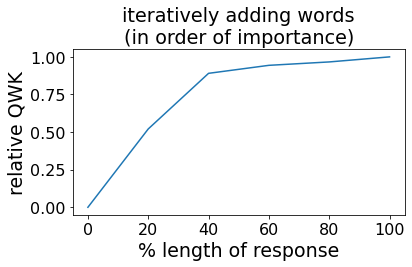

In [ ]:
d
plot_and_save(d,ATTRS_DIR+'adding_top.eps', x = '% length of response', y ='relative QWK', title= 'iteratively adding words\n(in order of importance)')

In [ ]:
# GET BOTTOM WORDS REMOVAL GRAPH

def bottom_k_attrs(tokens, attrs,k=None):
    k = min(k, len(tokens))
    return ([tokens[i] for i in np.argpartition(attrs, k)[:k]])

d2_keys = []
d2_vals = []
p_list = {}
for K in range(0,6):
  percent = K*0.2
  preds_new = []
  new_essay_list = []
  for id, essay in enumerate(essay_list):
    top_k = int(percent* len(attrs_list[id]))
    attrs = attrs_list[id]
    question_tokens = essay_list[id]
    attrs = [abs(x) for x in attrs]
    try:
      c_list = bottom_k_attrs(question_tokens[-len(attrs):] , attrs, k = top_k)
      # print(top_k, c_list)
    except Exception as e:
      c_list = list(set(question_tokens))
    if top_k==0:
      c_list = []
    
    count = 0
    new_essay = []
    for i in range(len(question_tokens[-len(attrs):])):  
      if question_tokens[-len(attrs):][i] in c_list and count<top_k:
        count +=1
        pass
      else:
        new_essay.append( question_tokens[-len(attrs):][i])
        
    # print(len(new_essay)/ len(question_tokens[-len(attrs):]))
    new_essay_padded = pad_sequences([new_essay], maxlen=MAX_SEQUENCE_LENGTH)[0]
    pred = adv.predict_and_norm(np.array([new_essay_padded]))[0]
    preds_new.append(pred)
    print(pred, pred_array_orig[id])
    
    if round(abs(pred - pred_array_orig[id])) == 1:
      # print('in')
      if id not in p_list.keys():
        p_list[id] = percent*100
      else:
        pass
    new_essay_list.append(new_essay_padded)

  # pred = adv.predict_and_norm(np.array(new_essay_list))
  # preds_new.extend(pred)
  
  acc = cohen_kappa_score(preds_new, pred_array_orig, weights='quadratic')
  # print(acc)
  get_pred_stats(pred_array_orig, preds_new, ATTRS_DIR+'stats_bottom.txt', int(100-percent*100))
  d2_keys.append(100-percent*100)
  d2_vals.append(acc)
  print('ddddddddddd')

25 25
17 17
19 19
26 26
16 16
25 25
21 21
16 16
8 8
6 6
24 24
10 10
15 15
8 8
19 19
17 17
27 27
15 15
8 8
15 15
26 26
14 14
14 15
20 20
22 22
7 8
26 26
26 26
16 16
15 15
15 15
12 12
19 19
22 22
28 28
19 19
25 25
14 16
27 27
26 26
16 16
18 18
17 17
13 13
26 26
17 17
15 15
16 16
14 14
9 10
22 22
8 9
17 17
13 14
24 24
19 19
21 21
24 24
14 14
15 15
25 25
26 26
22 22
24 24
19 19
27 27
26 26
17 17
14 14
8 8
24 24
19 19
22 22
20 20
19 19
27 27
26 26
26 26
18 18
22 22
16 16
6 6
11 11
25 25
17 17
13 13
15 15
6 8
9 9
17 17
19 19
17 17
17 17
12 12
11 12
15 15
10 10
21 21
18 18
18 18
23 23
7 7
23 23
27 27
8 8
18 18
22 22
23 23
27 27
25 25
27 27
18 18
26 26
13 13
28 28
22 22
19 19
21 21
17 17
24 24
16 16
20 20
17 18
25 25
18 18
7 7
25 25
26 26
20 20
18 18
24 24
27 27
15 15
16 16
12 12
21 21
25 25
11 10
17 17
7 7
9 9
16 16
19 19
26 26
24 24
18 18
17 17
24 24
17 17
9 9
28 28
25 25
13 13
22 22
15 15
12 12
18 18
23 23
24 24
25 25
25 25
23 23
22 22
19 19
13 13
7 7
24 24
20 20
6 6
8 8
14 14
8 8
6 6
15 15

In [ ]:
l = p_list.values()
sum(l)/len(l)

36.34782608695652

In [ ]:
count = 0
for i in p_list.values():
  if i == 20.0:
    count+=1
count/len(p_list.values())*100

55.172413793103445

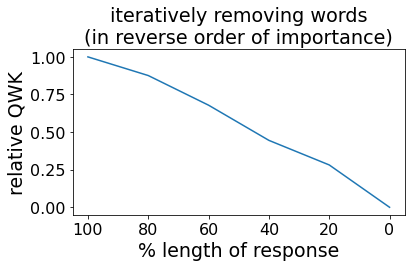

In [ ]:
plot_and_save_both(d2_keys, d2_vals, ATTRS_DIR+'removing_bottom', x = '% length of response', y ='relative QWK', title= 'iteratively removing words\n(in reverse order of importance)')


In [ ]:
d2_vals

[1.0,
 0.8816551688897831,
 0.6868413037611896,
 0.45992916317842125,
 0.28861349739035946,
 0.0]